In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import statistics

In [2]:
df = pd.read_csv('var3.csv')

In [3]:
df.describe()

,Unnamed: 0,X,y
count,200.000000,2.000000e+02,200.000000
mean,99.500000,1.421085e-16,0.312396
std,57.879185,2.326801e+00,31.846644
min,0.000000,-4.000000e+00,-93.957604
25%,49.750000,-2.000000e+00,-8.162983
50%,99.500000,-2.498002e-16,-0.062606
75%,149.250000,2.000000e+00,10.204757
max,199.000000,4.000000e+00,112.966234


<Axes: >

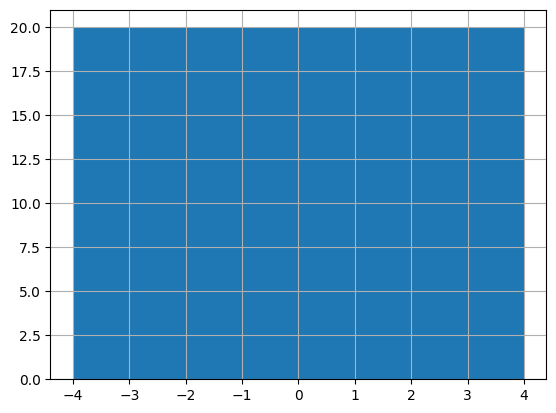

In [4]:
df['X'].hist() # Равномерное распределение (униформное)

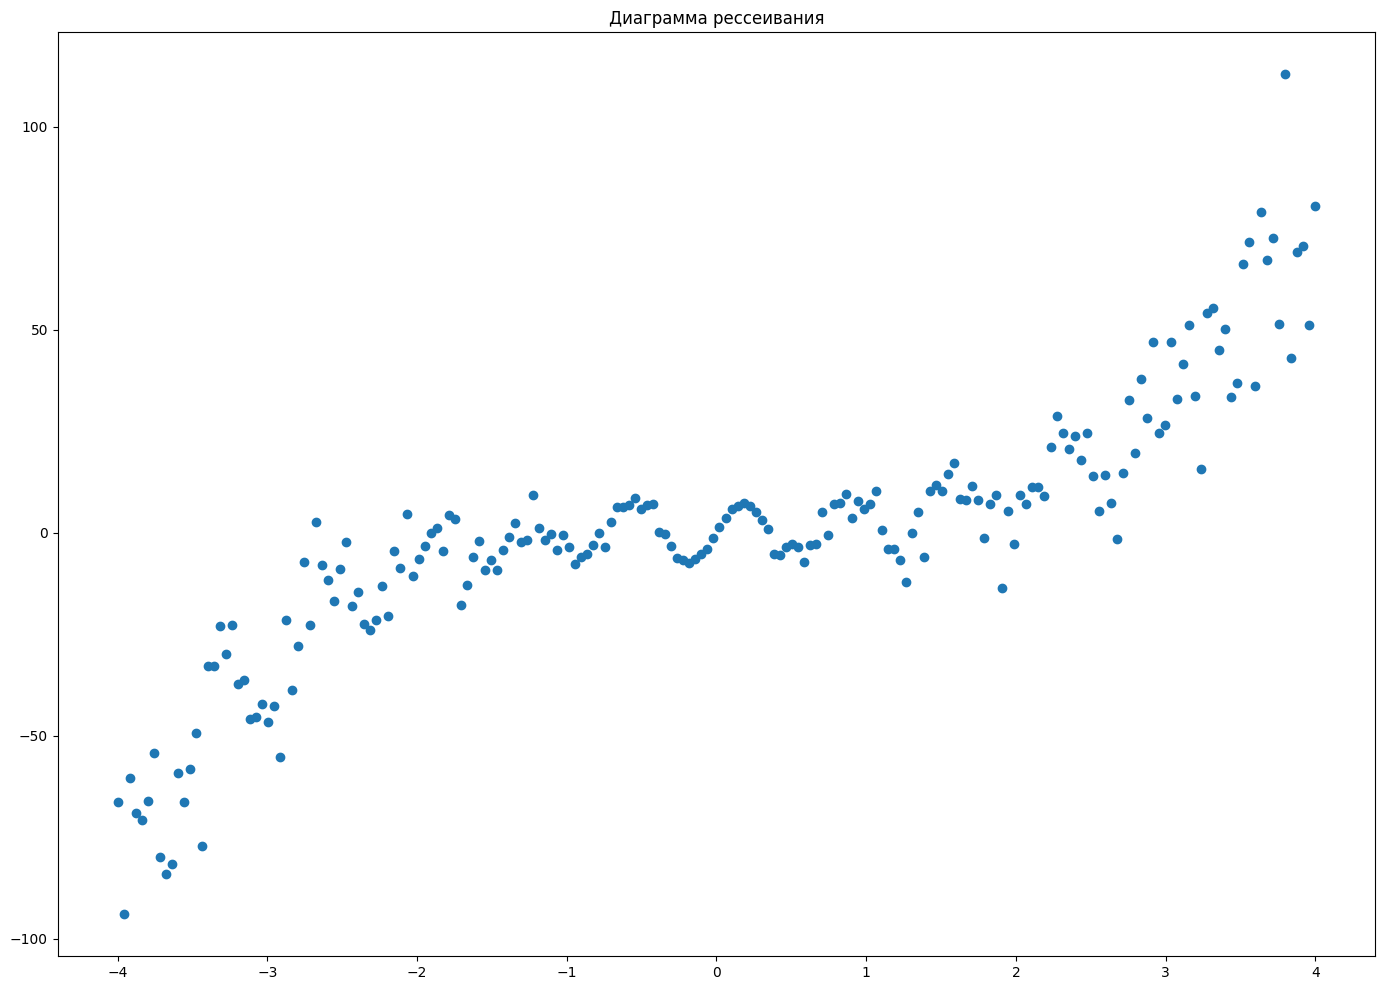

In [5]:
plt.figure(figsize=(17, 12))
plt.scatter(df['X'], df['y'])
plt.title('Диаграмма рессеивания')
plt.show()

In [6]:
# Попробуем разделить данные на 3 части в зависимости от плотности данных:

# 1 участок [-4; -1.25)

# 2 участок [-1.25; 1.25]

# 3 участок (1.25; 4]

df_1 = df[df['X'] < -1.25]
df_2 = df[(df['X'] >= -1.25) & (df['X'] <= 1.25)]
df_3 = df[df['X'] > 1.25]

X_1, y_1 = torch.tensor(df_1['X'].values.reshape(-1, 1), dtype=torch.float32), torch.tensor(df_1['y'].values.reshape(-1, 1), dtype=torch.float32)
X_2, y_2 = torch.tensor(df_2['X'].values.reshape(-1, 1), dtype=torch.float32), torch.tensor(df_2['y'].values.reshape(-1, 1), dtype=torch.float32)
X_3, y_3 = torch.tensor(df_3['X'].values.reshape(-1, 1), dtype=torch.float32), torch.tensor(df_3['y'].values.reshape(-1, 1), dtype=torch.float32)

X, y = torch.tensor(df['X'].values.reshape(-1, 1), dtype=torch.float32), torch.tensor(df['y'].values.reshape(-1, 1), dtype=torch.float32)

In [31]:
# Определение байесовского линейного слоя
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.weight_mu = nn.Parameter(torch.randn(out_features, in_features) * 0.1) # Для rho инициализация нулями более логична, так как при экспоненциальном преобразовании это даст начальное стандартное отклонение ~1.0; умножение на 0.1 сохраняет малый масштаб начальных значений
        self.weight_rho = nn.Parameter(torch.zeros(out_features, in_features))

        self.bias_mu = nn.Parameter(torch.randn(out_features) * 0.1)
        self.bias_rho = nn.Parameter(torch.zeros(out_features))

    def forward(self, x, sample=True):
        if sample:
            weight = self.weight_mu + torch.log1p(torch.exp(self.weight_rho)) * torch.randn_like(self.weight_rho)
            bias = self.bias_mu + torch.log1p(torch.exp(self.bias_rho)) * torch.randn_like(self.bias_rho)
        else:
            weight, bias = self.weight_mu, self.bias_mu
        return F.linear(x, weight, bias)

    def kl_divergence(self): # Упрощенный расчет KL без явного prior_sigma
        return 0.5 * (torch.sum(torch.log1p(torch.exp(self.weight_rho))**2 + torch.sum(torch.log1p(torch.exp(self.bias_rho))**2)))

# Определение байесовского нелинейного слоя
class BayesianNonlinear(nn.Module):
    def __init__(self, in_features, out_features, activation='sigmoid'):
        super().__init__()
        self.linear = BayesianLinear(in_features, out_features)
        self.activation = activation

    def forward(self, x, sample=True):
        x = self.linear(x, sample)
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

        return x  # Линейная активация

    def kl_divergence(self):
        return self.linear.kl_divergence()
    
class BNN_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinear(1, 50)
        self.layer2 = BayesianLinear(50, 50)
        self.layer3 = BayesianLinear(50, 1)
    
    def forward(self, x, sample=True):
        x = torch.relu(self.layer1(x, sample))
        x = torch.tanh(self.layer2(x, sample))
        return self.layer3(x, sample)
    
    def kl_loss(self):
        return self.layer1.kl_divergence() + self.layer2.kl_divergence() + self.layer3.kl_divergence()
 
class BNN_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinear(1, 20)
        self.layer2 = BayesianLinear(20, 1)
    
    def forward(self, x, sample=True):
        x = F.sigmoid(self.layer1(x, sample))
        x = self.layer2(x, sample)
 
        return x
    
    def kl_loss(self):
        return self.layer1.kl_divergence() + self.layer2.kl_divergence()

class BNN_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinear(1, 50)
        self.layer2 = BayesianLinear(50, 50)
        self.layer3 = BayesianLinear(50, 1)
    
    def forward(self, x, sample=True):
        x = torch.relu(self.layer1(x, sample))
        x = torch.tanh(self.layer2(x, sample))
        return self.layer3(x, sample)
    
    def kl_loss(self):
        return self.layer1.kl_divergence() + self.layer2.kl_divergence() + self.layer3.kl_divergence()

In [8]:
n_epochs = 50000

def train_model(model, optimizer, X, y):
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        preds = model(X)
        mse_loss = F.mse_loss(preds, y)
        kl_loss = model.kl_loss()
        total_loss = mse_loss + kl_loss / len(X)
        total_loss.backward()
        optimizer.step()
        
        if epoch % 300 == 0:
            print(f'Epoch {epoch}: MSE Loss = {mse_loss.item():.3f}, KL Loss = {kl_loss.item():.3f}')

        if mse_loss <= 14 and kl_loss <= 500:
            print(f"Остановка: MSE={mse_loss:.2f}, KL={kl_loss:.2f}")
            break
            
    return mse_loss.item(), kl_loss.item()

In [9]:
model1 = BNN_1()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
mse1, kl1 = train_model(model1, optimizer1, X_1, y_1)

Epoch 0: MSE Loss = 1591.902, KL Loss = 31265.482
Epoch 300: MSE Loss = 824.311, KL Loss = 3713.433
Epoch 600: MSE Loss = 694.023, KL Loss = 1974.283
Epoch 900: MSE Loss = 698.339, KL Loss = 1446.888
Epoch 1200: MSE Loss = 531.476, KL Loss = 1158.385
Epoch 1500: MSE Loss = 591.302, KL Loss = 963.446
Epoch 1800: MSE Loss = 292.547, KL Loss = 853.367
Epoch 2100: MSE Loss = 211.311, KL Loss = 773.972
Epoch 2400: MSE Loss = 138.894, KL Loss = 719.065
Epoch 2700: MSE Loss = 141.932, KL Loss = 676.502
Epoch 3000: MSE Loss = 126.984, KL Loss = 639.214
Epoch 3300: MSE Loss = 120.592, KL Loss = 607.187
Epoch 3600: MSE Loss = 126.409, KL Loss = 578.079
Epoch 3900: MSE Loss = 115.483, KL Loss = 550.618
Epoch 4200: MSE Loss = 103.996, KL Loss = 525.178
Epoch 4500: MSE Loss = 105.761, KL Loss = 500.335
Epoch 4800: MSE Loss = 100.205, KL Loss = 475.565
Epoch 5100: MSE Loss = 92.000, KL Loss = 451.536
Epoch 5400: MSE Loss = 92.224, KL Loss = 427.635
Epoch 5700: MSE Loss = 86.039, KL Loss = 403.347
Ep

In [10]:
model2 = BNN_2() 
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01) 
mse2, kl2 = train_model(model2, optimizer2, X_2, y_2)

Epoch 0: MSE Loss = 28.526, KL Loss = 110.504
Epoch 300: MSE Loss = 28.037, KL Loss = 26.006
Epoch 600: MSE Loss = 29.198, KL Loss = 11.644
Epoch 900: MSE Loss = 27.803, KL Loss = 6.738
Epoch 1200: MSE Loss = 27.850, KL Loss = 4.463
Epoch 1500: MSE Loss = 27.763, KL Loss = 3.162
Epoch 1800: MSE Loss = 28.004, KL Loss = 2.365
Epoch 2100: MSE Loss = 27.729, KL Loss = 1.821
Epoch 2400: MSE Loss = 27.645, KL Loss = 1.447
Epoch 2700: MSE Loss = 27.285, KL Loss = 1.165
Epoch 3000: MSE Loss = 26.602, KL Loss = 0.940
Epoch 3300: MSE Loss = 25.435, KL Loss = 0.762
Epoch 3600: MSE Loss = 23.736, KL Loss = 0.627
Epoch 3900: MSE Loss = 22.368, KL Loss = 0.519
Epoch 4200: MSE Loss = 21.046, KL Loss = 0.430
Epoch 4500: MSE Loss = 19.833, KL Loss = 0.356
Epoch 4800: MSE Loss = 18.303, KL Loss = 0.287
Epoch 5100: MSE Loss = 16.653, KL Loss = 0.243
Epoch 5400: MSE Loss = 15.058, KL Loss = 0.194
Остановка: MSE=13.99, KL=0.18


In [32]:
model3 = BNN_3()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01)
mse3, kl3 = train_model(model3, optimizer3, X_3, y_3)

Epoch 0: MSE Loss = 1270.738, KL Loss = 31265.482
Epoch 300: MSE Loss = 676.631, KL Loss = 3640.629
Epoch 600: MSE Loss = 638.714, KL Loss = 1972.607
Epoch 900: MSE Loss = 642.874, KL Loss = 1484.900
Epoch 1200: MSE Loss = 371.400, KL Loss = 1206.734
Epoch 1500: MSE Loss = 265.807, KL Loss = 1008.883
Epoch 1800: MSE Loss = 229.823, KL Loss = 888.840
Epoch 2100: MSE Loss = 223.289, KL Loss = 796.611
Epoch 2400: MSE Loss = 220.710, KL Loss = 733.328
Epoch 2700: MSE Loss = 171.304, KL Loss = 685.395
Epoch 3000: MSE Loss = 207.855, KL Loss = 643.372
Epoch 3300: MSE Loss = 209.512, KL Loss = 605.955
Epoch 3600: MSE Loss = 154.983, KL Loss = 574.511
Epoch 3900: MSE Loss = 147.610, KL Loss = 544.839
Epoch 4200: MSE Loss = 146.102, KL Loss = 517.977
Epoch 4500: MSE Loss = 143.242, KL Loss = 493.116
Epoch 4800: MSE Loss = 143.768, KL Loss = 468.931
Epoch 5100: MSE Loss = 147.990, KL Loss = 444.885
Epoch 5400: MSE Loss = 135.865, KL Loss = 420.992
Epoch 5700: MSE Loss = 135.113, KL Loss = 396.94

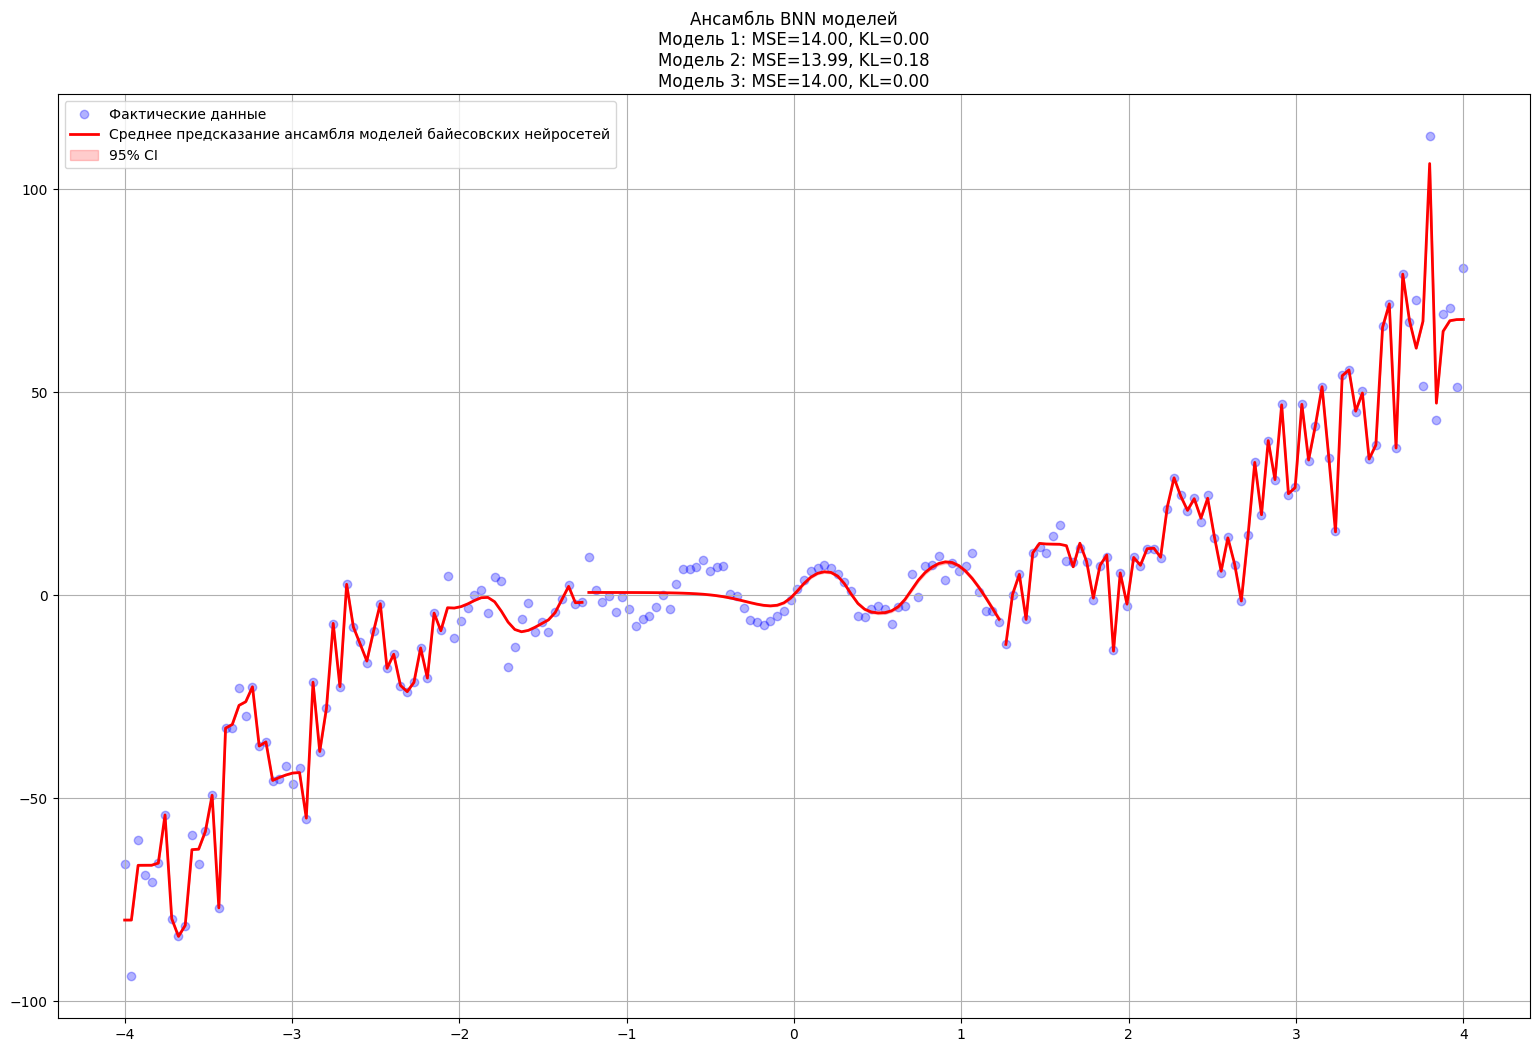

In [33]:
model1.eval()
model2.eval()
model3.eval()
    
with torch.no_grad():
    samples1 = [model1(X_1).numpy() for _ in range(100)]
    samples2 = [model2(X_2).numpy() for _ in range(100)]
    samples3 = [model3(X_3).numpy() for _ in range(100)]
        
    y_mean1 = np.mean(samples1, axis=0)
    y_mean2 = np.mean(samples2, axis=0)
    y_mean3 = np.mean(samples3, axis=0)
    
    y_std1 = np.std(samples1, axis=0)
    y_std2 = np.std(samples2, axis=0)
    y_std3 = np.std(samples3, axis=0)

plt.figure(figsize=(19, 12))
plt.scatter(X_1.numpy(), y_1.numpy(), alpha=0.3, label='Фактические данные', color='blue')
plt.plot(X_1.numpy(), y_mean1, 'r', lw=2, label='Среднее предсказание ансамбля моделей байесовских нейросетей')
plt.fill_between(X_1.numpy().ravel(), 
                y_mean1.ravel() - 2*y_std1.ravel(),
                y_mean1.ravel() + 2*y_std1.ravel(),
                alpha=0.2, color='r')
plt.scatter(X_2.numpy(), y_2.numpy(), alpha=0.3, color='blue')
plt.plot(X_2.numpy(), y_mean2, 'r', lw=2)
plt.fill_between(X_2.numpy().ravel(), 
                y_mean2.ravel() - 2*y_std2.ravel(),
                y_mean2.ravel() + 2*y_std2.ravel(),
                alpha=0.2, color='r')
plt.scatter(X_3.numpy(), y_3.numpy(), alpha=0.3, color='blue')
plt.plot(X_3.numpy(), y_mean3, 'r', lw=2)
plt.fill_between(X_3.numpy().ravel(), 
                y_mean3.ravel() - 2*y_std3.ravel(),
                y_mean3.ravel() + 2*y_std3.ravel(),
                alpha=0.2, color='r', label='95% CI')
plt.legend()
plt.title(f'Ансамбль BNN моделей\n'
          f'Модель 1: MSE={mse1:.2f}, KL={kl1:.2f}\n'
          f'Модель 2: MSE={mse2:.2f}, KL={kl2:.2f}\n'
          f'Модель 3: MSE={mse3:.2f}, KL={kl3:.2f}')
plt.grid(True)
plt.show()

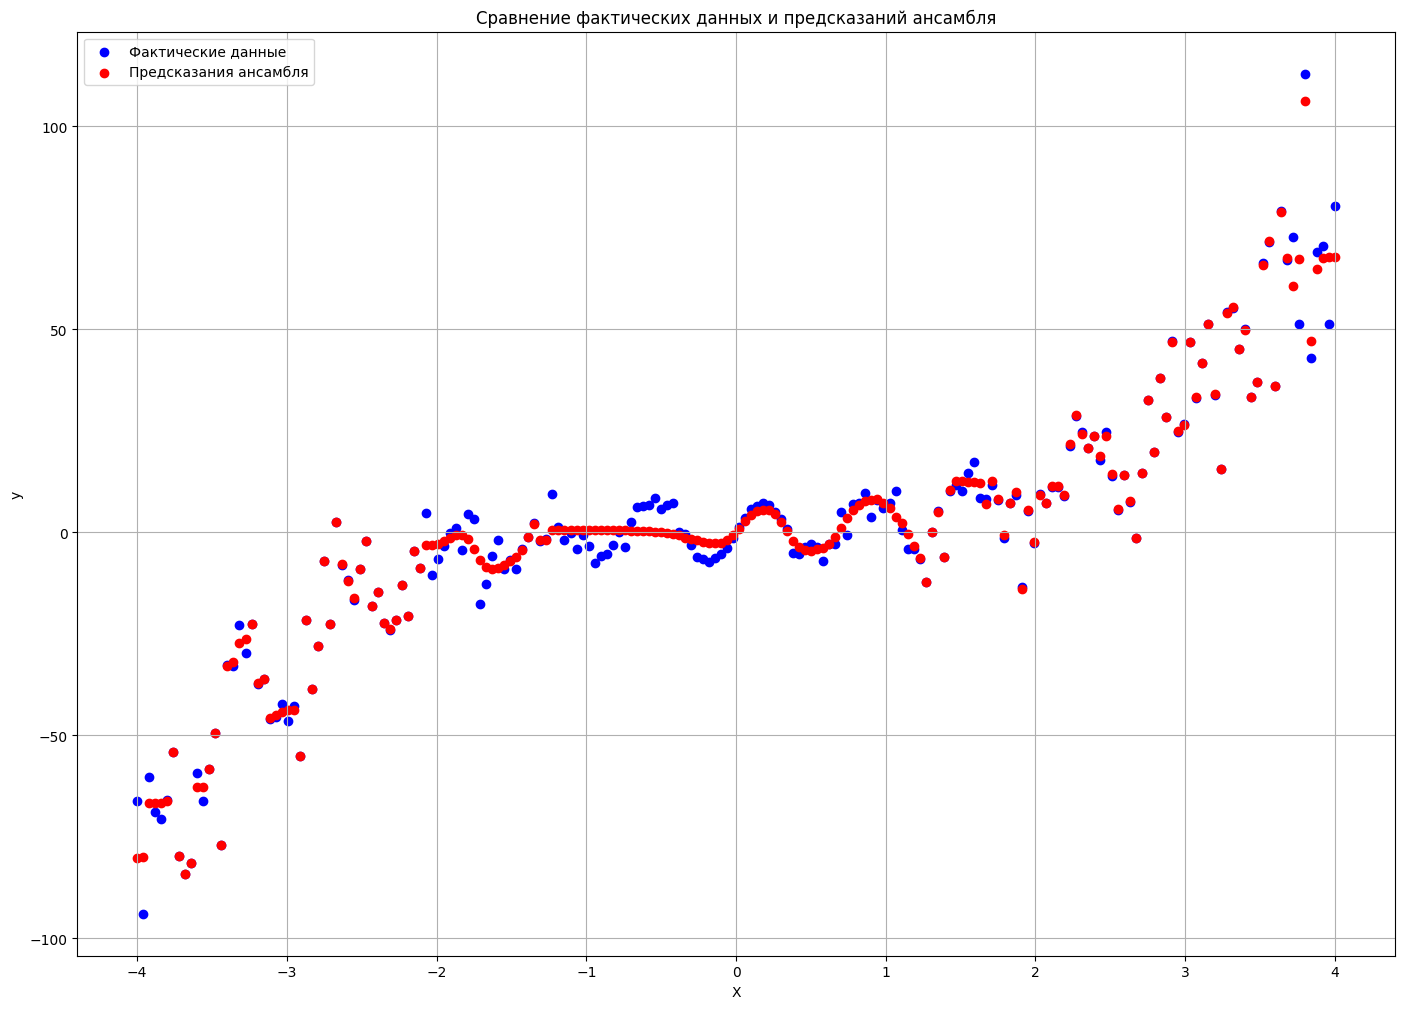

In [34]:
X_pred = torch.linspace(-4, 4, 200).unsqueeze(1)  # 200 точек от -4 до 4
models = [model1, model2, model3]  # Создаем экземпляры моделей

def ensemble_predict(models, X):
    predictions = []
    for x in X: 
        x_val = x.item()  
        with torch.no_grad():
            if x_val < -1.25:
                pred = models[0](x.unsqueeze(0)).numpy()
            elif x_val > 1.25:
                pred = models[2](x.unsqueeze(0)).numpy()
            else:
                pred = models[1](x.unsqueeze(0)).numpy()
            predictions.append(pred)
    return np.concatenate(predictions) 

y_pred = ensemble_predict(models, X_pred)

plt.figure(figsize=(17, 12))
plt.scatter(X_1.numpy(), y_1.numpy(), color='blue', label='Фактические данные')
plt.scatter(X_2.numpy(), y_2.numpy(), color='blue')
plt.scatter(X_3.numpy(), y_3.numpy(), color='blue')
plt.scatter(X_pred.numpy(), y_pred, color='red', label='Предсказания ансамбля')
plt.title('Сравнение фактических данных и предсказаний ансамбля')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()

In [35]:
def get_model_formuls(model, model_name):
    equations = []
    
    # Получаем параметры всех слоев
    for name, param in model.named_parameters():
        if 'mu' in name:  # Берем только средние значения
            equations.append(f"{name}: {param.data.numpy().shape}")
    
    # Для BNN_1
    if model_name == "BNN_1":
        W1 = model.layer1.weight_mu.detach().numpy()
        b1 = model.layer1.bias_mu.detach().numpy()
        W2 = model.layer2.weight_mu.detach().numpy()
        b2 = model.layer2.bias_mu.detach().numpy()
        W3 = model.layer3.weight_mu.detach().numpy()
        b3 = model.layer3.bias_mu.detach().numpy()
        
        eq1 = f"h1 = ReLU({W1[0][0]:.3f}*x + {b1[0]:.3f})"
        eq2 = f"h2 = tanh({W2[0][0]:.3f}*h1 + {b2[0]:.3f})"
        eq3 = f"y = {W3[0][0]:.3f}*h2 + {b3[0]:.3f}"
        
        return [eq1, eq2, eq3]
    
    # Для BNN_2
    elif model_name == "BNN_2":
        W1 = model.layer1.weight_mu.detach().numpy()
        b1 = model.layer1.bias_mu.detach().numpy()
        W2 = model.layer2.weight_mu.detach().numpy()
        b2 = model.layer2.bias_mu.detach().numpy()
        
        eq1 = f"h1 = sigmoid({W1[0][0]:.3f}*x + {b1[0]:.3f})"
        eq2 = f"y = {W2[0][0]:.3f}*h1 + {b2[0]:.3f}"
        
        return [eq1, eq2]
    
    # Для BNN_3
    elif model_name == "BNN_3":
        W1 = model.layer1.weight_mu.detach().numpy()
        b1 = model.layer1.bias_mu.detach().numpy()
        W2 = model.layer2.weight_mu.detach().numpy()
        b2 = model.layer2.bias_mu.detach().numpy()
        W3 = model.layer3.weight_mu.detach().numpy()
        b3 = model.layer3.bias_mu.detach().numpy()
        
        eq1 = f"h1 = ReLU({W1[0][0]:.3f}*x + {b1[0]:.3f})"
        eq2 = f"h2 = tanh({W2[0][0]:.3f}*h1 + {b2[0]:.3f})"
        eq3 = f"y = {W3[0][0]:.3f}*h2 + {b3[0]:.3f}"
        
        return [eq1, eq2, eq3]

# Получаем уравнения для всех моделей
print("Модель 1 (x < -1.25):")
for eq in get_model_formuls(model1, "BNN_1"):
    print(eq)

print("\nМодель 2 [-1.25 ≤ x ≤ 1.25]:")
for eq in get_model_formuls(model2, "BNN_2"):
    print(eq)

print("\nМодель 3 (x > 1.25):")
for eq in get_model_formuls(model3, "BNN_3"):
    print(eq)

Модель 1 (x < -1.25):
h1 = ReLU(0.355*x + -1.308)
h2 = tanh(-0.012*h1 + 6.499)
y = 2.398*h2 + -3.202

Модель 2 [-1.25 ≤ x ≤ 1.25]:
h1 = sigmoid(1.294*x + -2.055)
y = -0.169*h1 + 0.388

Модель 3 (x > 1.25):
h1 = ReLU(-0.311*x + -1.783)
h2 = tanh(0.077*h1 + -8.132)
y = -18.529*h2 + -3.799


In [119]:
def model1_equation(x):
    # Получаем параметры модели и преобразуем в списки
    W1 = [[0.35532647371292114],
 [0.7618318200111389],
 [0.551875114440918],
 [0.7352932095527649],
 [0.2883208394050598],
 [0.504727840423584],
 [0.3898986876010895],
 [0.6434113383293152],
 [-3.1021902561187744],
 [0.08933935314416885],
 [0.29295614361763],
 [0.7593609094619751],
 [0.6710381507873535],
 [-0.06014865264296532],
 [0.6711412668228149],
 [0.8130528926849365],
 [0.25700315833091736],
 [0.9473515748977661],
 [-1.7588980197906494],
 [0.9822145700454712],
 [0.6615886092185974],
 [0.6816624402999878],
 [0.8567885160446167],
 [0.38199976086616516],
 [0.6699969172477722],[0.500424861907959],
 [0.26541826128959656],
 [0.16773949563503265],
 [0.3701592981815338],
 [0.10394162684679031],
 [0.8107427954673767],
 [2.4923298358917236],
 [0.6205387115478516],
 [0.3268256187438965],
 [0.6702566742897034],
 [0.5386474132537842],
 [0.31343984603881836],
 [0.4296225905418396],
 [0.47435781359672546],
 [0.46896103024482727],
 [0.778450071811676],
 [0.28476235270500183],
 [0.8925821781158447],
 [0.17446261644363403],
 [0.2329944223165512],
 [0.7527974247932434],
 [0.2716624140739441],
 [0.2178133875131607],
 [0.3768693804740906],
 [1.8660260438919067]]
    b1 = [-1.3078172206878662,
 -1.6126400232315063,
 -1.780693531036377,
 -1.0395317077636719,
 -2.0439441204071045,
 -2.022796869277954,
 -1.7585461139678955,
 -0.783882200717926,
 -6.4341888427734375,
 -2.3808114528656006,
 -2.2243263721466064,
 -1.3507136106491089,
 -0.44127750396728516,
 -1.9714345932006836,
 -1.5519073009490967,
 -1.3044720888137817,
 -1.416703701019287,
 -0.975487470626831,
 -5.524530410766602,
 -0.9350633025169373,
 -1.8824591636657715,
 -1.0032939910888672,
 -1.2381782531738281,
 -2.1840720176696777,
 -1.1895941495895386,
 -1.656046986579895,
 -1.7027230262756348,
 -1.9229745864868164,
 -2.290342092514038,
 -2.264768362045288,
 -1.337037205696106,
 3.5716795921325684,
 -1.3538626432418823,
 -1.9488434791564941,
 -0.3934243619441986,
 -1.870255470275879,
 -1.6940112113952637,
 -1.0729522705078125,
 -1.5443434715270996,
 -1.167351484298706,
 -1.086344838142395,
 -2.1036744117736816,
 -1.1546785831451416,
 -1.7634912729263306,
 -1.911263108253479,
 -1.2216898202896118,
 -1.4866485595703125,
 -2.2220115661621094,
 -2.0798630714416504,
 7.386772155761719]
    W2 = [[-0.012495785020291805,
  -0.16705025732517242,
  -0.31965509057044983,
  -0.8796716928482056,
  -0.4482545256614685,
  -0.11950790137052536,
  -0.09740560501813889,
  0.18354076147079468,
  -2.649071455001831,
  -0.17112721502780914,
  -0.324178010225296,
  -0.07850972563028336,
  0.1056910902261734,
  -0.14759230613708496,
  0.061504967510700226,
  -0.4033889174461365,
  -0.16198664903640747,
  0.010522939264774323,
  -13.389790534973145,
  -0.34413763880729675,
  -0.2188289612531662,
  0.18974363803863525,
  -0.3272087872028351,
  -0.060121651738882065,
  0.3067067563533783,
  0.09278405457735062,
  -0.07046780735254288,
  0.29227784276008606,
  -0.24716369807720184,
  -0.1933281570672989,
  -0.058194033801555634,
  0.5044759511947632,
  0.17392247915267944,
  0.1169387549161911,
  0.08542076498270035,
  -0.08471782505512238,
  -0.2108786255121231,
  -0.2511827051639557,
  -0.30783480405807495,
  0.053198885172605515,
  0.06765633821487427,
  -0.04131424054503441,
  0.17114730179309845,
  -0.0664534866809845,
  0.06663171201944351,
  0.21771444380283356,
  -0.23943991959095,
  -0.16798555850982666,
  0.0018189215334132314,
  11.950948715209961],
 [-0.05216512456536293,
  0.17367319762706757,
  0.16145724058151245,
  0.12909919023513794,
  0.26777076721191406,
  0.19819022715091705,
  0.29016202688217163,
  -0.23192711174488068,
  12.83174991607666,
  0.48512428998947144,
  0.8100006580352783,
  0.20624172687530518,
  0.22520604729652405,
  -0.28989148139953613,
  -0.01993476040661335,
  0.45982062816619873,
  -0.2688889503479004,
  0.16892611980438232,
  0.9430367350578308,
  -0.5310383439064026,
  -0.012802916578948498,
  0.15075238049030304,
  -0.09832201153039932,
  0.6042782068252563,
  -0.3896316885948181,
  -0.08019354194402695,
  0.3174680173397064,
  0.2902210056781769,
  0.7673931121826172,
  0.5904093980789185,
  -0.20240691304206848,
  0.14602027833461761,
  0.27424156665802,
  -0.034522101283073425,
  0.07499494403600693,
  0.23258639872074127,
  0.4222736060619354,
  0.8957956433296204,
  0.30801132321357727,
  0.040024902671575546,
  0.3585314452648163,
  0.32629480957984924,
  -0.07272742688655853,
  0.03144005686044693,
  0.612847089767456,
  0.20628301799297333,
  0.431770384311676,
  0.66690993309021,
  -0.12563957273960114,
  -8.567180633544922],
 [0.03189140558242798,
  0.26286250352859497,
  0.25803762674331665,
  -0.10587435215711594,
  0.5478746294975281,
  0.6243425011634827,
  0.2098366767168045,
  0.6424450278282166,
  11.437750816345215,
  -0.20587992668151855,
  0.499895840883255,
  -0.22098824381828308,
  -0.1551404446363449,
  1.00182044506073,
  0.1464916467666626,
  0.2795310318470001,
  0.1917315274477005,
  0.7258543372154236,
  0.6903789043426514,
  -0.16449767351150513,
  -0.03523419052362442,
  0.1863439679145813,
  0.3761524558067322,
  -0.17998820543289185,
  0.3735353946685791,
  0.4306446611881256,
  0.4611128568649292,
  0.1416003704071045,
  0.681127667427063,
  -0.032247889786958694,
  0.09903045743703842,
  -0.46516504883766174,
  -0.009923464618623257,
  0.7180470824241638,
  -0.1343814879655838,
  0.18371771275997162,
  0.023913143202662468,
  -0.06075600907206535,
  0.32811158895492554,
  -0.21576841175556183,
  0.10851408541202545,
  -0.08902639895677567,
  0.23283982276916504,
  0.30539947748184204,
  0.2780991196632385,
  0.46391788125038147,
  -0.018325334414839745,
  0.14711825549602509,
  -0.12570148706436157,
  -3.630418539047241],
 [0.3741116225719452,
  0.41118377447128296,
  0.37805473804473877,
  0.06854960322380066,
  0.47947973012924194,
  0.6916252374649048,
  0.07511303573846817,
  0.8809912204742432,
  7.200623989105225,
  0.5260116457939148,
  0.6240221858024597,
  0.027010150253772736,
  0.6185431480407715,
  0.6266900897026062,
  -0.20511490106582642,
  -0.022680237889289856,
  0.2400617152452469,
  0.6247674822807312,
  0.5449022650718689,
  0.43993672728538513,
  0.616052508354187,
  0.31962665915489197,
  0.5055733323097229,
  0.9575638771057129,
  0.36023345589637756,
  0.35978126525878906,
  0.5460530519485474,
  0.5590490102767944,
  0.7703748941421509,
  0.12965156137943268,
  0.3021697700023651,
  -2.0250966548919678,
  0.4665161371231079,
  0.18327490985393524,
  0.2055775672197342,
  0.9141311645507812,
  0.49666911363601685,
  0.1605617105960846,
  0.499483585357666,
  -0.37050509452819824,
  0.32059192657470703,
  0.2739642262458801,
  0.2037263959646225,
  0.45028388500213623,
  0.15766359865665436,
  0.42770400643348694,
  0.5123180747032166,
  0.3480929136276245,
  0.24924533069133759,
  5.58823299407959],
 [0.03721892088651657,
  0.04680192843079567,
  0.25454244017601013,
  0.17573325335979462,
  0.4477303922176361,
  0.23557700216770172,
  -0.050248969346284866,
  0.36720791459083557,
  2.236013650894165,
  -0.2557498812675476,
  -0.24469879269599915,
  0.004204940516501665,
  -0.6114751100540161,
  -0.05081601068377495,
  0.3467109501361847,
  0.27637559175491333,
  -0.02455628104507923,
  0.38369518518447876,
  16.052448272705078,
  0.6964529156684875,
  0.20908530056476593,
  0.6753342151641846,
  0.09371877461671829,
  -0.30219000577926636,
  0.03798039257526398,
  0.2708006203174591,
  0.11954323947429657,
  0.3558516502380371,
  -0.16068679094314575,
  -0.013008072972297668,
  -0.10987264662981033,
  0.5343472957611084,
  0.06937392801046371,
  0.3061579763889313,
  0.20925849676132202,
  -0.12015208601951599,
  -0.262920081615448,
  0.11441051214933395,
  0.22089917957782745,
  0.2835336923599243,
  0.06781890243291855,
  0.41205427050590515,
  0.09624195098876953,
  -0.24939505755901337,
  -0.10366708040237427,
  -0.1506713628768921,
  -0.05887624993920326,
  0.19579540193080902,
  0.23416726291179657,
  -16.459299087524414],
 [-0.04199826344847679,
  -0.04748062416911125,
  0.036288466304540634,
  0.2598639726638794,
  -0.2545922100543976,
  0.24232247471809387,
  0.41243427991867065,
  0.11780901998281479,
  14.331070899963379,
  0.525078535079956,
  0.2567123472690582,
  0.11679621785879135,
  0.42187201976776123,
  0.12091749161481857,
  -0.16608251631259918,
  0.14695236086845398,
  0.45582833886146545,
  0.4264521300792694,
  0.9588215351104736,
  -0.22123627364635468,
  -0.06779537349939346,
  -0.1019672304391861,
  0.34849485754966736,
  0.04410405084490776,
  -0.10829690098762512,
  0.127460777759552,
  0.34978416562080383,
  0.520420253276825,
  0.14114490151405334,
  0.517624020576477,
  0.09202263504266739,
  -0.5585843920707703,
  -0.4508098065853119,
  0.3641456067562103,
  0.11891067028045654,
  -0.026551825925707817,
  0.03332456946372986,
  0.31464239954948425,
  0.32602953910827637,
  -0.02278069593012333,
  0.02236766368150711,
  -0.1290963590145111,
  -0.21057306230068207,
  -0.17033632099628448,
  -0.13257786631584167,
  -0.26547467708587646,
  -0.04321897029876709,
  0.1140439435839653,
  -0.0946064442396164,
  -4.091684341430664],
 [0.3732033669948578,
  -0.07667788863182068,
  -0.43096625804901123,
  -0.18987742066383362,
  -0.11391593515872955,
  -0.32025548815727234,
  -0.08663920313119888,
  0.05633305385708809,
  -2.173933744430542,
  0.12722346186637878,
  0.08456012606620789,
  -0.3125399947166443,
  0.15281490981578827,
  -0.18163304030895233,
  -0.19743165373802185,
  -0.3164936900138855,
  -0.07319466769695282,
  0.021127434447407722,
  -16.023096084594727,
  -0.1520126312971115,
  -0.30356475710868835,
  0.19090090692043304,
  -0.028848666697740555,
  -0.2271624207496643,
  -0.5707026720046997,
  -0.4215092957019806,
  -0.397388219833374,
  -0.5617104768753052,
  -0.24136309325695038,
  -0.041971128433942795,
  0.22420616447925568,
  -0.159546360373497,
  -0.44836845993995667,
  -0.3448260426521301,
  -0.17812421917915344,
  -0.4827156066894531,
  -0.1612984985113144,
  0.15220828354358673,
  0.16074474155902863,
  0.1320497989654541,
  -0.6786431670188904,
  -0.842741072177887,
  -0.23305800557136536,
  -0.09236340969800949,
  -0.29575279355049133,
  -0.3224109411239624,
  -0.27469807863235474,
  -0.2725033760070801,
  -0.4973345100879669,
  24.621807098388672],
 [-0.40139326453208923,
  -0.28847789764404297,
  0.03564170002937317,
  -0.1340675801038742,
  -0.6208373308181763,
  -0.307014137506485,
  -0.6234733462333679,
  -0.3344666361808777,
  -0.6980466842651367,
  -0.37197625637054443,
  -0.14864122867584229,
  -0.4224351942539215,
  -0.13836535811424255,
  -0.3327454924583435,
  -0.7701319456100464,
  -0.1727510690689087,
  -0.4314459264278412,
  -0.24418799579143524,
  -17.78382110595703,
  -0.21260857582092285,
  -0.39818453788757324,
  -0.376646488904953,
  -0.17961108684539795,
  -0.424178808927536,
  -0.41848525404930115,
  -0.33301374316215515,
  -0.24538281559944153,
  -0.7979770302772522,
  -0.5592028498649597,
  -0.17460007965564728,
  -0.7407152056694031,
  1.7611736059188843,
  -0.3068903982639313,
  -0.333791047334671,
  -0.7406498193740845,
  -0.5099061727523804,
  -0.751041829586029,
  -0.7420903444290161,
  -0.27379125356674194,
  -0.5724470019340515,
  -0.4265403747558594,
  -0.2367699146270752,
  -0.1120312511920929,
  -0.5550991892814636,
  -0.3123123049736023,
  -0.12888310849666595,
  -0.7944173216819763,
  -0.789631187915802,
  -0.6031086444854736,
  -1.1774613857269287],
 [-0.20176814496517181,
  -0.03337413817644119,
  0.23080259561538696,
  0.04546138271689415,
  0.3568809926509857,
  -0.1725127249956131,
  0.25680047273635864,
  -0.09479493647813797,
  -2.755613088607788,
  -0.11517920345067978,
  -0.0013158125802874565,
  0.5014779567718506,
  0.059962186962366104,
  0.15742148458957672,
  0.226408913731575,
  -0.37939706444740295,
  -0.25229424238204956,
  0.07698050141334534,
  -22.248376846313477,
  0.15527531504631042,
  0.25154969096183777,
  -0.12881861627101898,
  -0.33303484320640564,
  -0.4413186013698578,
  0.3919871747493744,
  -0.25155577063560486,
  -0.06034596264362335,
  0.41639086604118347,
  -0.2349337488412857,
  0.29635316133499146,
  0.09653306007385254,
  -0.1637890487909317,
  -0.055889613926410675,
  0.3659297823905945,
  0.05459195375442505,
  0.4392542243003845,
  -0.01713545061647892,
  0.29796895384788513,
  -0.3967752754688263,
  0.2234356552362442,
  0.09646027535200119,
  -0.1430262178182602,
  -0.12135592848062515,
  0.09415432810783386,
  -0.12411975860595703,
  0.015245816670358181,
  -0.1141510009765625,
  -0.10227537155151367,
  -0.018748421221971512,
  19.6027889251709],
 [0.08258335292339325,
  -0.29089200496673584,
  0.18057218194007874,
  0.1796167641878128,
  -0.15704622864723206,
  0.3114559054374695,
  -0.026640677824616432,
  -0.7635238766670227,
  -21.07327651977539,
  -0.030155066400766373,
  -0.19800519943237305,
  0.1874050348997116,
  0.10016530752182007,
  0.27676406502723694,
  -0.18509745597839355,
  -0.03212812915444374,
  0.23466330766677856,
  0.012900094501674175,
  -0.15358249843120575,
  -0.1615840196609497,
  -0.5321394205093384,
  -0.24996119737625122,
  0.1678944230079651,
  0.03259510174393654,
  0.004049896728247404,
  0.15809357166290283,
  0.1275942027568817,
  0.06629560887813568,
  0.13441212475299835,
  0.11947908997535706,
  0.18795159459114075,
  -18.283723831176758,
  0.22291259467601776,
  -0.0905793234705925,
  0.25202620029449463,
  -0.016039224341511726,
  0.1843113899230957,
  0.009548368863761425,
  -0.2640867531299591,
  -0.25326791405677795,
  -0.33431556820869446,
  0.1692565232515335,
  -0.28710412979125977,
  0.1683356612920761,
  -0.059921491891145706,
  0.1339075267314911,
  -0.5560228228569031,
  -0.054172273725271225,
  -0.01264271978288889,
  1.539170265197754],
 [0.09281765669584274,
  0.4148343503475189,
  -0.05672478303313255,
  0.13078360259532928,
  -0.10541146248579025,
  0.4729468822479248,
  0.5739980936050415,
  0.29116353392601013,
  12.71841049194336,
  0.19923673570156097,
  0.08835657685995102,
  0.28990182280540466,
  -0.218599334359169,
  0.1613907366991043,
  0.32005682587623596,
  0.22938619554042816,
  -0.4345128536224365,
  -0.23814551532268524,
  0.7531665563583374,
  0.07370556890964508,
  0.23455002903938293,
  0.19384627044200897,
  -0.11420148611068726,
  0.5607929825782776,
  0.09590775519609451,
  -0.4941810071468353,
  0.04400867223739624,
  0.4909372627735138,
  0.47308945655822754,
  -0.06517864018678665,
  0.27298372983932495,
  -0.9340800046920776,
  0.2815838158130646,
  0.5324631333351135,
  -0.3704755902290344,
  0.6405919790267944,
  0.30701014399528503,
  0.11052485555410385,
  -0.16815420985221863,
  -0.3195418417453766,
  0.23056839406490326,
  0.5927912592887878,
  0.14872407913208008,
  -0.28919142484664917,
  0.4116794168949127,
  -0.10984846204519272,
  0.2135915607213974,
  0.6617226600646973,
  -0.34981125593185425,
  -10.78085708618164],
 [-0.043223802000284195,
  0.343227356672287,
  0.11841937899589539,
  0.27354246377944946,
  0.49131765961647034,
  0.2466745376586914,
  0.5511831641197205,
  0.6882761120796204,
  1.8508497476577759,
  0.18096664547920227,
  0.5765888690948486,
  0.18954969942569733,
  0.5397955775260925,
  -0.17403201758861542,
  0.47366583347320557,
  0.26837724447250366,
  0.47619420289993286,
  0.1713191568851471,
  2.50606107711792,
  0.80315101146698,
  0.6685404181480408,
  0.09342978894710541,
  -0.01623685657978058,
  0.46186989545822144,
  0.2862313985824585,
  0.6407223343849182,
  0.2895823121070862,
  0.7719643712043762,
  0.6181027889251709,
  0.7188757658004761,
  0.7158230543136597,
  -1.6208086013793945,
  0.5350226163864136,
  0.7964577674865723,
  0.7574998140335083,
  0.5668420195579529,
  0.3642023801803589,
  -0.23892511427402496,
  0.18032439053058624,
  0.8761838674545288,
  0.29162850975990295,
  0.40844985842704773,
  0.4598558843135834,
  0.4465031325817108,
  0.46051284670829773,
  0.37863239645957947,
  0.7057608962059021,
  0.27443018555641174,
  1.0364068746566772,
  1.4298275709152222],
 [-0.5368937849998474,
  -0.21848216652870178,
  -0.20580582320690155,
  -0.21500533819198608,
  -0.21534433960914612,
  -0.11342404037714005,
  -0.2381991744041443,
  -0.26915740966796875,
  -0.13438408076763153,
  0.07485417276620865,
  -1.2632770538330078,
  0.061041876673698425,
  0.02038840390741825,
  0.036025553941726685,
  0.02219945751130581,
  -0.57772296667099,
  -0.13058249652385712,
  -0.3586311936378479,
  -6.856875419616699,
  0.08901547640562057,
  0.06542680412530899,
  -0.15957531332969666,
  -0.32511043548583984,
  -0.5853992104530334,
  0.3364669978618622,
  -0.005802116356790066,
  -0.6158724427223206,
  -0.5100439190864563,
  -0.7239816784858704,
  -0.3608427345752716,
  -0.5634456276893616,
  -0.3237989842891693,
  -0.10481131821870804,
  -0.2733156681060791,
  0.06459015607833862,
  -0.16220173239707947,
  -0.400701105594635,
  0.04178307205438614,
  -0.26715192198753357,
  -0.1612216681241989,
  -0.32936757802963257,
  -0.26493188738822937,
  0.06646378338336945,
  -0.13648036122322083,
  0.0018158028833568096,
  -0.20246918499469757,
  -0.35314568877220154,
  -0.6462329030036926,
  -0.29559436440467834,
  89.73981475830078],
 [-0.7324085831642151,
  -0.10510889440774918,
  -0.4163621962070465,
  -0.19553589820861816,
  -0.14471231400966644,
  -0.7245362401008606,
  -0.44920411705970764,
  -0.304303914308548,
  -1.7231636047363281,
  -0.4721912443637848,
  -0.5356658101081848,
  -0.45895618200302124,
  -0.13984371721744537,
  -0.4794648289680481,
  -0.17197288572788239,
  -0.41503843665122986,
  -0.558617889881134,
  -0.44588950276374817,
  -0.9896964430809021,
  -0.3185325562953949,
  -0.48355385661125183,
  -0.8186564445495605,
  -0.275938481092453,
  -0.23623470962047577,
  0.33510926365852356,
  -0.4715290367603302,
  -0.22351086139678955,
  -0.38839077949523926,
  -0.28026482462882996,
  -0.492012083530426,
  -0.044805411249399185,
  0.8480285406112671,
  -0.10369040071964264,
  -0.7792874574661255,
  -0.41179925203323364,
  -0.7524608373641968,
  -0.1643594652414322,
  -0.10818624496459961,
  -0.5099790096282959,
  -0.2741641402244568,
  -0.3575216829776764,
  -0.582594096660614,
  -0.4659106135368347,
  -0.0448082759976387,
  -0.4503014087677002,
  -0.46029287576675415,
  -0.6988728046417236,
  -0.2906699478626251,
  0.34906700253486633,
  -1.0134952068328857],
 [0.5783790349960327,
  -0.18202422559261322,
  -0.038718272000551224,
  -0.20384038984775543,
  -0.09154539555311203,
  -0.4171387553215027,
  -0.09637390077114105,
  0.2489863634109497,
  -4.188553810119629,
  -0.6530182361602783,
  -0.407105028629303,
  -0.2162027806043625,
  0.09644939750432968,
  -0.5870683193206787,
  -0.020739544183015823,
  -0.11373278498649597,
  -0.4240645170211792,
  -0.06114615499973297,
  -30.036710739135742,
  0.07095414400100708,
  0.1258469521999359,
  -0.13565653562545776,
  -0.03296198695898056,
  -0.17976967990398407,
  -0.20019082725048065,
  -0.34077519178390503,
  -0.6086638569831848,
  -0.23335681855678558,
  0.0536121241748333,
  -0.846950113773346,
  0.2622176706790924,
  0.301329642534256,
  0.28110164403915405,
  -0.19960488379001617,
  0.0008686687797307968,
  0.03857067599892616,
  -0.37958547472953796,
  -0.5562535524368286,
  0.27139246463775635,
  -0.10792190581560135,
  0.06397995352745056,
  -0.4179481863975525,
  -0.4745810925960541,
  -0.19719433784484863,
  -0.29003965854644775,
  0.16299311816692352,
  0.22894985973834991,
  0.19939742982387543,
  -0.45464417338371277,
  10.444931983947754],
 [-0.29923391342163086,
  -0.3223435878753662,
  -0.23313941061496735,
  -0.04899976775050163,
  -0.0654950812458992,
  -0.21852557361125946,
  -0.4935596287250519,
  -0.1785510778427124,
  -1.5449854135513306,
  -0.23391571640968323,
  0.003531156573444605,
  -0.6336049437522888,
  -0.6973034739494324,
  -0.32539987564086914,
  -0.20441602170467377,
  -0.2491452693939209,
  -0.10190195590257645,
  -0.548912763595581,
  -0.26778700947761536,
  -0.1092471107840538,
  -0.15996119379997253,
  -0.49382105469703674,
  -0.3074663281440735,
  -0.25660955905914307,
  -0.6122273802757263,
  -0.29819273948669434,
  -0.629135251045227,
  -0.22593416273593903,
  -0.27119067311286926,
  -0.6483604907989502,
  -0.12047731876373291,
  -0.10471267253160477,
  -0.576338529586792,
  -0.5561445951461792,
  -0.20030836760997772,
  -0.23072297871112823,
  -0.26086974143981934,
  -0.07581368088722229,
  0.04484044760465622,
  -0.32136034965515137,
  0.021775459870696068,
  -0.8165254592895508,
  -0.09992790967226028,
  -0.05054110661149025,
  -0.4150305390357971,
  0.11335786432027817,
  -0.6028856039047241,
  0.18082864582538605,
  0.014417372643947601,
  -1.1443555355072021],
 [-0.4856533706188202,
  -0.10233853757381439,
  -0.50987309217453,
  -0.1914198249578476,
  -0.3477324843406677,
  -0.5318050980567932,
  -0.05194125324487686,
  -0.5630617737770081,
  -0.8065888285636902,
  -0.5186310410499573,
  -0.9103750586509705,
  -0.08962374180555344,
  0.10659316927194595,
  -0.7063742876052856,
  -0.5651568174362183,
  -0.11042854189872742,
  -0.749514639377594,
  -0.2099379301071167,
  -16.888654708862305,
  -0.13453416526317596,
  -0.5874341130256653,
  -0.41211214661598206,
  -0.2919585108757019,
  -0.32069334387779236,
  -0.36588382720947266,
  -0.262935072183609,
  -0.27034956216812134,
  -0.09975428879261017,
  -0.29606691002845764,
  -0.38016781210899353,
  -0.06775732338428497,
  1.8139501810073853,
  -0.26262637972831726,
  -0.23682034015655518,
  -0.2807476222515106,
  -0.17706115543842316,
  -0.4769236743450165,
  -0.6559909582138062,
  -0.22909420728683472,
  -0.30432918667793274,
  -0.05170077458024025,
  -0.04019010066986084,
  -0.19562143087387085,
  -0.45069456100463867,
  -0.6238239407539368,
  -0.5076261758804321,
  -0.6263444423675537,
  -0.8232178688049316,
  -0.25968876481056213,
  -1.2950903177261353],
 [0.49061042070388794,
  0.2907896041870117,
  0.34210968017578125,
  0.35075053572654724,
  -0.6151859760284424,
  0.2685087025165558,
  0.21972130239009857,
  0.6527519226074219,
  14.992024421691895,
  0.22509759664535522,
  0.7126744389533997,
  -0.22113369405269623,
  0.2846072018146515,
  0.5976263284683228,
  0.1696963757276535,
  0.22447791695594788,
  0.0014121565036475658,
  0.024549931287765503,
  1.3313699960708618,
  0.3804900050163269,
  0.3897674083709717,
  0.24190865457057953,
  0.31938767433166504,
  0.6353765726089478,
  1.0739705562591553,
  0.6358457803726196,
  0.4630694091320038,
  0.3720068633556366,
  0.6586111783981323,
  0.0832449346780777,
  0.04331725463271141,
  -0.036994338035583496,
  -0.006947983987629414,
  0.34890666604042053,
  -0.2420734167098999,
  0.18845894932746887,
  0.7997671961784363,
  0.23288585245609283,
  0.2575179636478424,
  0.24315913021564484,
  0.19364500045776367,
  0.3457014262676239,
  0.5714333057403564,
  0.9645994305610657,
  0.1779579371213913,
  -0.4063216745853424,
  0.3737125098705292,
  0.213963121175766,
  0.5261557102203369,
  -6.475759029388428],
 [-0.402784526348114,
  -0.3299541175365448,
  -0.23605279624462128,
  -0.04027252271771431,
  -0.638248860836029,
  -0.25771743059158325,
  -0.254925400018692,
  -0.42804282903671265,
  -0.7778195738792419,
  -0.9418067932128906,
  -0.1721716672182083,
  -0.28180044889450073,
  -0.2138543277978897,
  -0.4897497892379761,
  -0.4945768713951111,
  -0.2033342868089676,
  -0.44974592328071594,
  -0.12072298675775528,
  -18.015583038330078,
  -0.3849855065345764,
  -0.27187463641166687,
  0.023986542597413063,
  -0.579514741897583,
  0.0276083592325449,
  -0.3917408883571625,
  -0.05290144309401512,
  0.022936349734663963,
  -0.7553155422210693,
  -0.9268380403518677,
  -0.6299236416816711,
  -0.09980542212724686,
  1.7592145204544067,
  -0.6156224012374878,
  -0.4076578915119171,
  -0.38897693157196045,
  -0.6690691113471985,
  -0.74510657787323,
  -0.5205549001693726,
  -0.3922484815120697,
  -0.13051150739192963,
  -0.26032930612564087,
  -0.8615173697471619,
  -0.3366509974002838,
  -0.7657710313796997,
  -0.503557562828064,
  -0.5253373384475708,
  -0.17613700032234192,
  -0.41085076332092285,
  -0.5239936709403992,
  -1.371321201324463],
 [-0.20772065222263336,
  0.15754085779190063,
  0.3456704020500183,
  0.24228306114673615,
  0.32193881273269653,
  0.34462136030197144,
  0.3477749526500702,
  0.0985572561621666,
  12.522665977478027,
  0.6479494571685791,
  0.26859116554260254,
  0.6666958928108215,
  0.020791053771972656,
  0.24417109787464142,
  -0.05624770373106003,
  -0.14025621116161346,
  -0.13333965837955475,
  -0.2801920473575592,
  0.4552118182182312,
  0.5166696310043335,
  0.2724899351596832,
  0.17449167370796204,
  0.14578017592430115,
  0.0632374957203865,
  0.3124218285083771,
  0.10217105597257614,
  -0.16036757826805115,
  0.19172188639640808,
  0.5141940116882324,
  -0.0774274468421936,
  0.2492651790380478,
  -0.11767706274986267,
  -0.0717143714427948,
  -0.28997862339019775,
  0.004219324328005314,
  0.6313718557357788,
  -0.204581156373024,
  0.14249876141548157,
  0.46795448660850525,
  0.3112626075744629,
  0.011070964857935905,
  -0.00915931724011898,
  -0.43052324652671814,
  -0.39540040493011475,
  0.1508912295103073,
  -0.3482559025287628,
  0.5720869898796082,
  0.535572350025177,
  -0.20750419795513153,
  -12.421018600463867],
 [0.18943054974079132,
  0.05737705156207085,
  -0.6395833492279053,
  -0.13589291274547577,
  -0.33121296763420105,
  -0.6337589025497437,
  -0.7382887601852417,
  0.19018858671188354,
  -20.48560905456543,
  -0.38209715485572815,
  -0.291502982378006,
  -0.23348088562488556,
  0.08219549059867859,
  0.15938803553581238,
  -0.10962453484535217,
  -0.24130180478096008,
  -0.81327885389328,
  -0.6189916729927063,
  -0.7076239585876465,
  -0.11451998353004456,
  -0.30914318561553955,
  0.07767258584499359,
  0.20463378727436066,
  -0.7159268260002136,
  -0.03173316642642021,
  -0.3795318007469177,
  -0.012668386101722717,
  -0.36975035071372986,
  -0.5376265048980713,
  -0.351455956697464,
  0.2699291706085205,
  0.14156590402126312,
  -0.1211293563246727,
  -0.4114799201488495,
  -0.4245419204235077,
  -0.26122215390205383,
  -0.9593579173088074,
  -0.20322872698307037,
  -0.719054639339447,
  -0.23187203705310822,
  -0.1348811537027359,
  -0.1528521478176117,
  -0.22263103723526,
  -0.3545600473880768,
  -0.11414725333452225,
  -0.7142578363418579,
  0.2997264862060547,
  -0.26259565353393555,
  -0.3112441599369049,
  7.445005416870117],
 [0.04733218997716904,
  -0.21015013754367828,
  -0.12446236610412598,
  0.274730384349823,
  -0.3086584508419037,
  0.1305590122938156,
  0.10401753336191177,
  -0.1773933470249176,
  14.44191837310791,
  0.4705299139022827,
  0.2201768308877945,
  -0.2910726070404053,
  0.19320213794708252,
  -0.3386911451816559,
  -0.3252567648887634,
  0.364058256149292,
  0.13829593360424042,
  0.5956357717514038,
  0.8710845112800598,
  0.47783252596855164,
  0.733471691608429,
  0.5782099962234497,
  0.381104052066803,
  0.08933901786804199,
  0.22344452142715454,
  0.368735671043396,
  0.2490667998790741,
  0.08340651541948318,
  0.24819937348365784,
  0.24827030301094055,
  0.3616037964820862,
  -0.7489080429077148,
  0.6208179593086243,
  -0.05234258249402046,
  0.056498993188142776,
  0.48607978224754333,
  0.13080266118049622,
  -0.0518665611743927,
  0.6074480414390564,
  0.7767359018325806,
  0.39069485664367676,
  0.2840157151222229,
  0.36029526591300964,
  0.628401517868042,
  0.26327425241470337,
  0.593336820602417,
  0.6858732104301453,
  0.3027084469795227,
  0.4970429539680481,
  -15.751673698425293],
 [0.2786598801612854,
  0.5235716104507446,
  0.3628782033920288,
  0.3214639723300934,
  0.594059407711029,
  0.23034605383872986,
  0.7397900223731995,
  0.7437868118286133,
  1.666700005531311,
  0.6721964478492737,
  0.20879164338111877,
  0.5364992022514343,
  -0.12422817200422287,
  0.9912314414978027,
  0.6221709251403809,
  0.2582677900791168,
  0.5258110165596008,
  0.3342271149158478,
  8.76314926147461,
  0.9472387433052063,
  0.15441231429576874,
  0.478266179561615,
  0.816718578338623,
  0.6322271823883057,
  -0.19329917430877686,
  0.4154205322265625,
  0.8222514986991882,
  0.5662589073181152,
  0.6705541610717773,
  0.47490575909614563,
  0.6600578427314758,
  -1.770530104637146,
  0.36203670501708984,
  0.35985857248306274,
  0.8573902249336243,
  0.39282816648483276,
  0.27228066325187683,
  0.4744550287723541,
  0.7120788097381592,
  0.8024855256080627,
  0.23054374754428864,
  0.2794303297996521,
  -0.07619919627904892,
  0.6265636086463928,
  0.7165313363075256,
  0.3982808589935303,
  0.6418643593788147,
  0.5332379341125488,
  0.3780364394187927,
  1.591489315032959],
 [0.3973613381385803,
  0.1662837117910385,
  -0.03510301932692528,
  -0.008268190547823906,
  0.7403634786605835,
  -0.11023139953613281,
  -0.3987540006637573,
  -0.2642962634563446,
  7.549846649169922,
  -0.08147066831588745,
  0.4032977521419525,
  -0.26027488708496094,
  -0.12429247796535492,
  -0.10648644715547562,
  -0.13577282428741455,
  -0.1809329390525818,
  0.3779679834842682,
  -0.5696037411689758,
  4.059851169586182,
  -0.06474032253026962,
  0.12174119055271149,
  -0.3551936447620392,
  -0.1132572814822197,
  -0.20914781093597412,
  0.13490808010101318,
  0.5822324752807617,
  0.7933506369590759,
  0.06974390894174576,
  0.48983579874038696,
  0.12927672266960144,
  0.08094204217195511,
  -0.33095744252204895,
  -0.07429390400648117,
  0.23355242609977722,
  0.2113432139158249,
  0.3204917311668396,
  -0.06972486525774002,
  -0.10604175925254822,
  -0.2606874108314514,
  -0.23709039390087128,
  0.030829014256596565,
  0.12759187817573547,
  0.03722935542464256,
  0.340339720249176,
  0.09911596775054932,
  -0.32376542687416077,
  -0.037672922015190125,
  0.27769383788108826,
  -0.09001996368169785,
  -5.733162879943848],
 [-0.05094470828771591,
  -0.11651434004306793,
  -0.3078487813472748,
  -0.1202063038945198,
  -0.5538401007652283,
  -0.5549337267875671,
  -0.05031304061412811,
  -0.6115388870239258,
  -0.7225505709648132,
  -0.3846050202846527,
  -0.3411266803741455,
  -0.7171148061752319,
  -0.189870223402977,
  -0.7773705124855042,
  -0.8386309742927551,
  -0.18620046973228455,
  -0.5232464075088501,
  -0.6459869742393494,
  -17.844234466552734,
  -0.6737647652626038,
  -0.5660178661346436,
  -0.4146864712238312,
  -0.5748095512390137,
  -0.5630264282226562,
  -0.5925585031509399,
  -0.40212538838386536,
  -0.23203317821025848,
  -0.8484163284301758,
  -0.3629683554172516,
  -0.42854297161102295,
  -0.5662674903869629,
  1.831804633140564,
  -0.7207778096199036,
  -0.355127215385437,
  -0.42654648423194885,
  -0.29828765988349915,
  -0.4220229387283325,
  -0.3815825879573822,
  0.16029413044452667,
  -0.5508866310119629,
  -0.3235093057155609,
  -0.41265997290611267,
  -0.2964230179786682,
  -0.2775779962539673,
  -0.6052509546279907,
  -0.829612135887146,
  -0.5302284359931946,
  -0.44387659430503845,
  -0.5350523591041565,
  -1.1866704225540161],
 [0.8076666593551636,
  -0.05139433220028877,
  0.16080953180789948,
  0.17318326234817505,
  0.6072823405265808,
  0.1299799233675003,
  0.6388058066368103,
  0.06829001754522324,
  1.4484431743621826,
  0.10679031908512115,
  0.287869393825531,
  0.20856763422489166,
  0.29130467772483826,
  0.5288388133049011,
  0.6038752198219299,
  0.09417781978845596,
  0.28448721766471863,
  0.36340242624282837,
  16.346420288085938,
  0.3509174883365631,
  0.13988611102104187,
  -0.147372767329216,
  0.35254889726638794,
  0.21247287094593048,
  0.47387969493865967,
  0.4645487070083618,
  0.13675585389137268,
  0.1666107177734375,
  0.07975439727306366,
  0.6899121403694153,
  0.09021425247192383,
  5.710165977478027,
  0.42583757638931274,
  0.2555471956729889,
  0.4916609525680542,
  0.6058313250541687,
  0.4104234278202057,
  0.2925925850868225,
  0.08639390766620636,
  0.46455711126327515,
  -0.03089083358645439,
  0.1791323870420456,
  0.3379064202308655,
  0.5739681720733643,
  0.3170575797557831,
  0.20318487286567688,
  0.3530162274837494,
  0.3842352330684662,
  0.28938478231430054,
  -1.2501410245895386],
 [0.23615360260009766,
  -0.28873470425605774,
  0.09048055112361908,
  0.07246393710374832,
  -0.05203713849186897,
  -0.315952867269516,
  -0.28422993421554565,
  -0.43318474292755127,
  -0.415335476398468,
  -0.16087009012699127,
  -0.04196016862988472,
  -0.29764655232429504,
  -0.2861870229244232,
  -0.26796048879623413,
  0.1473708301782608,
  -0.18882234394550323,
  -0.010735956951975822,
  0.17803369462490082,
  -10.460186958312988,
  -0.30043983459472656,
  -0.3561650216579437,
  -0.048215560615062714,
  -0.2650314271450043,
  -0.5413609743118286,
  -0.3315441310405731,
  -0.2757909893989563,
  -0.5200707316398621,
  -0.16730529069900513,
  -0.34796231985092163,
  -0.08400548249483109,
  -0.1687064915895462,
  -0.3065822422504425,
  0.10060473531484604,
  0.1435142606496811,
  -0.0640275701880455,
  -0.03931964561343193,
  -0.12577812373638153,
  -0.3199580907821655,
  -0.5002132058143616,
  0.13566654920578003,
  0.20519018173217773,
  -0.07977990806102753,
  0.03518259525299072,
  0.09054502844810486,
  -0.21272306144237518,
  -0.17430411279201508,
  -0.20491847395896912,
  -0.1618286371231079,
  -0.08646494895219803,
  23.211336135864258],
 [-0.49581801891326904,
  -0.17193123698234558,
  -0.5735712647438049,
  -0.17114228010177612,
  -0.41288065910339355,
  -0.5085797309875488,
  -0.38495078682899475,
  -0.2937048077583313,
  -1.6449822187423706,
  -0.276498407125473,
  -0.9453243613243103,
  -0.2901669442653656,
  -0.18122641742229462,
  -0.33075210452079773,
  -0.5569959878921509,
  -0.2429913878440857,
  -0.6029220819473267,
  0.2777813673019409,
  -10.269454002380371,
  -0.5986281037330627,
  -0.3528934419155121,
  -0.6557074785232544,
  -0.07044357061386108,
  -0.10092412680387497,
  -0.0425410196185112,
  -0.43281659483909607,
  -0.30037128925323486,
  -0.5503472685813904,
  -0.1934942901134491,
  -0.4321777820587158,
  -0.3901912569999695,
  1.848829746246338,
  -0.7229516506195068,
  -0.37144792079925537,
  -0.4413914084434509,
  -0.6838966608047485,
  -0.667729914188385,
  -0.7418428063392639,
  -0.7941520810127258,
  -0.5812912583351135,
  -0.3241759240627289,
  -0.42931991815567017,
  -0.5871654152870178,
  -0.45745939016342163,
  -0.23297709226608276,
  -0.32333752512931824,
  -0.8835504055023193,
  -0.6775206327438354,
  -0.4947208762168884,
  -1.636316180229187],
 [-0.3194871246814728,
  -0.20795567333698273,
  0.0912269800901413,
  0.007914979010820389,
  -0.8587262630462646,
  -0.38833650946617126,
  -0.3991333842277527,
  0.2921280562877655,
  48.052005767822266,
  0.3103143870830536,
  0.22222553193569183,
  -0.29118144512176514,
  0.3600965738296509,
  0.32604897022247314,
  0.4056699872016907,
  0.352771520614624,
  0.0701725110411644,
  -0.179652601480484,
  0.5681639909744263,
  0.4278412461280823,
  0.19461816549301147,
  0.2475922703742981,
  0.0756649523973465,
  0.20903685688972473,
  -0.1443335860967636,
  0.33720752596855164,
  -0.1949438750743866,
  0.30917730927467346,
  0.05863020569086075,
  0.6183822154998779,
  0.09813772141933441,
  -0.35821732878685,
  -0.5067020058631897,
  -0.045869380235672,
  0.0555824339389801,
  0.1677718162536621,
  0.04147328436374664,
  0.1782795935869217,
  -0.1925659030675888,
  0.4667220115661621,
  0.19666829705238342,
  0.03186068311333656,
  -0.3441257178783417,
  -0.013025115244090557,
  0.412137508392334,
  -0.03763537108898163,
  0.18989862501621246,
  0.1437467336654663,
  -0.16935501992702484,
  -4.371832370758057],
 [0.0713161826133728,
  0.7230695486068726,
  0.21426047384738922,
  0.13497893512248993,
  0.13730336725711823,
  0.07965099811553955,
  -0.02821466699242592,
  0.2847377359867096,
  -2.217180013656616,
  0.14409004151821136,
  0.34366482496261597,
  0.5159368515014648,
  0.3744085133075714,
  0.8571059107780457,
  0.07444269955158234,
  0.18499986827373505,
  0.6923056244850159,
  -0.04564632475376129,
  19.819578170776367,
  0.5589302182197571,
  0.47117072343826294,
  0.19486285746097565,
  0.41548481583595276,
  0.2285347580909729,
  0.5484870672225952,
  0.4434044659137726,
  0.5335375666618347,
  0.4328412413597107,
  0.3197713792324066,
  0.16426105797290802,
  0.10334570705890656,
  0.5186928510665894,
  0.19705858826637268,
  0.41957005858421326,
  0.8744324445724487,
  0.30528998374938965,
  0.5314057469367981,
  0.487301766872406,
  0.1473739892244339,
  0.3618141710758209,
  0.24237175285816193,
  0.33812910318374634,
  0.6368164420127869,
  0.6064124703407288,
  0.4505375623703003,
  0.1587144136428833,
  0.38901153206825256,
  0.30055543780326843,
  0.4566214978694916,
  1.7538338899612427],
 [0.34340015053749084,
  -0.03721403703093529,
  0.659700334072113,
  0.21434839069843292,
  0.5361970067024231,
  -0.4300864338874817,
  0.02909385971724987,
  0.07118815928697586,
  14.803979873657227,
  0.9059857130050659,
  0.4061676859855652,
  0.43221408128738403,
  0.38517269492149353,
  0.10496186465024948,
  0.5813872218132019,
  0.06332092732191086,
  0.2725178301334381,
  0.37878647446632385,
  0.37651053071022034,
  0.3007127344608307,
  0.02863302081823349,
  0.1695648431777954,
  0.2228870838880539,
  0.3312825858592987,
  -0.6255635619163513,
  -0.27863383293151855,
  -0.6460058093070984,
  0.19621610641479492,
  0.1722288727760315,
  0.04125445336103439,
  -0.22478602826595306,
  -0.20094960927963257,
  -0.002258606255054474,
  0.2625790238380432,
  -0.1605200171470642,
  -0.0856102854013443,
  0.40912795066833496,
  -0.11249633878469467,
  0.45269566774368286,
  0.0970785841345787,
  0.05915223807096481,
  0.4521191418170929,
  0.0926498994231224,
  0.19706740975379944,
  0.03934367746114731,
  0.1546056568622589,
  0.06742069125175476,
  0.14866741001605988,
  0.3289799094200134,
  -15.720205307006836],
 [0.5299896597862244,
  -0.033640891313552856,
  0.454862117767334,
  0.41347891092300415,
  0.25148043036460876,
  1.1175508499145508,
  0.41384637355804443,
  0.7954970598220825,
  1.9918767213821411,
  0.9498900175094604,
  0.29339152574539185,
  0.611519455909729,
  0.4451662302017212,
  0.6792690753936768,
  0.27941974997520447,
  -0.073502317070961,
  0.643128514289856,
  -0.05633582919836044,
  17.670673370361328,
  0.5358783006668091,
  0.5151829719543457,
  0.027105677872896194,
  0.5226166248321533,
  0.8764790892601013,
  0.29123780131340027,
  0.1598077118396759,
  0.4204203486442566,
  0.4617650508880615,
  0.28313148021698,
  0.06187988445162773,
  0.22638872265815735,
  -1.1797765493392944,
  0.12156540900468826,
  0.6561441421508789,
  0.480979859828949,
  0.2422960251569748,
  0.2880977690219879,
  -0.04769156128168106,
  0.6346748471260071,
  -0.013243583962321281,
  0.09357145428657532,
  0.5602051615715027,
  0.3879537284374237,
  0.3597138524055481,
  0.3660314083099365,
  0.6355066299438477,
  0.7276760339736938,
  0.6152544617652893,
  0.4925219416618347,
  3.1757614612579346],
 [-0.4597380459308624,
  -0.1863039880990982,
  -0.37602663040161133,
  0.14114248752593994,
  0.038375552743673325,
  -0.6863643527030945,
  -0.7540108561515808,
  -0.1666489839553833,
  -11.358428955078125,
  -0.36420708894729614,
  -0.8294684290885925,
  0.031471073627471924,
  0.11447653919458389,
  -0.24500997364521027,
  -1.198091983795166,
  -0.35964465141296387,
  -0.30151650309562683,
  0.052496250718832016,
  -0.24435067176818848,
  -0.6050448417663574,
  -0.29678383469581604,
  -0.032052408903837204,
  0.08126778900623322,
  -0.9000446200370789,
  -0.5057604908943176,
  -0.5946105122566223,
  -0.2488468885421753,
  -0.4992668926715851,
  -0.48281329870224,
  -0.7552484273910522,
  -0.472959965467453,
  0.08898372203111649,
  -0.39248040318489075,
  -0.2405056208372116,
  -0.12775948643684387,
  -0.08430644124746323,
  -0.28318527340888977,
  0.24975097179412842,
  0.14138461649417877,
  -0.662651777267456,
  -0.3138977289199829,
  -0.41520074009895325,
  -0.07336372882127762,
  -0.25975897908210754,
  0.11032374203205109,
  0.11780167371034622,
  0.0741400346159935,
  -1.1595247983932495,
  -0.8361935615539551,
  12.578394889831543],
 [-0.19927798211574554,
  0.07654085755348206,
  0.1982431560754776,
  -0.17098422348499298,
  -0.544444739818573,
  -0.18891377747058868,
  -0.5790380239486694,
  0.06813045591115952,
  -16.1990966796875,
  -0.38453030586242676,
  -0.04195909947156906,
  0.023041725158691406,
  -0.2226056456565857,
  -0.5897952318191528,
  -0.02143791876733303,
  0.07206151634454727,
  0.1659366339445114,
  -0.031216135248541832,
  -0.7041533589363098,
  0.03424949571490288,
  -0.33604446053504944,
  -0.18619462847709656,
  -0.5415260195732117,
  -0.33078891038894653,
  0.22625556588172913,
  0.013197640888392925,
  -0.09371725469827652,
  -0.01324540376663208,
  0.048758674412965775,
  -0.31324660778045654,
  0.0901409462094307,
  -0.004923949483782053,
  0.20140554010868073,
  -0.22081217169761658,
  0.1253553032875061,
  -0.20745816826820374,
  -0.15467260777950287,
  0.30323028564453125,
  -0.2553957402706146,
  0.04996442049741745,
  -0.09755806624889374,
  -0.20618611574172974,
  0.19259266555309296,
  0.34532102942466736,
  -0.4485759437084198,
  0.3682791292667389,
  -0.017938900738954544,
  0.024331312626600266,
  0.14726027846336365,
  11.0042142868042],
 [0.11427968740463257,
  0.304849773645401,
  -0.011422716081142426,
  0.10651569068431854,
  -0.04892803356051445,
  0.0027326736599206924,
  0.11664930731058121,
  -0.2971283197402954,
  3.4630632400512695,
  0.512139618396759,
  -0.1201721802353859,
  0.029721133410930634,
  0.039402369409799576,
  0.20885775983333588,
  0.23567605018615723,
  0.2399260252714157,
  0.3865536153316498,
  -0.5626571178436279,
  19.44318962097168,
  0.2720305025577545,
  0.053353480994701385,
  -0.015787839889526367,
  0.27471402287483215,
  0.1886589527130127,
  0.08538860082626343,
  0.12812794744968414,
  0.16643933951854706,
  0.3871399760246277,
  0.16548867523670197,
  0.32551607489585876,
  0.2547980546951294,
  -1.1496857404708862,
  0.24475637078285217,
  0.3136405944824219,
  -0.36891356110572815,
  0.24687041342258453,
  -0.5457280874252319,
  0.1904686540365219,
  0.024601617828011513,
  -0.3261103630065918,
  -0.2708788514137268,
  0.3311717212200165,
  0.17210225760936737,
  0.1921670138835907,
  0.4002839922904968,
  -0.2760639488697052,
  0.5170574188232422,
  0.3377693295478821,
  0.07916329056024551,
  -14.67943286895752],
 [0.038358308374881744,
  0.034593917429447174,
  -0.18206991255283356,
  0.04076342284679413,
  -0.2971893846988678,
  0.1894502192735672,
  -0.25087594985961914,
  -0.45388877391815186,
  -23.288000106811523,
  -0.06293825060129166,
  0.10402125120162964,
  0.41800209879875183,
  0.0501706525683403,
  -0.023430220782756805,
  -0.12527289986610413,
  0.022781183943152428,
  -0.10394051671028137,
  0.4020629823207855,
  -0.004102492704987526,
  -0.5075935125350952,
  -0.2476547360420227,
  -0.22934585809707642,
  0.0020510233007371426,
  -0.27832239866256714,
  0.4436606764793396,
  -0.1630331575870514,
  -0.04464741796255112,
  -0.293788880109787,
  0.2595076560974121,
  0.4063013792037964,
  0.018379900604486465,
  0.650536835193634,
  0.29667118191719055,
  0.07628343999385834,
  -0.2506975531578064,
  0.0833953395485878,
  -0.09425532072782516,
  -0.1487407237291336,
  -0.26130494475364685,
  0.03480307757854462,
  0.09914978593587875,
  0.18744614720344543,
  -0.2412085384130478,
  0.055030472576618195,
  0.08831985294818878,
  0.00045986141776666045,
  -0.2661362290382385,
  -0.02915269136428833,
  -0.12582215666770935,
  3.9434280395507812],
 [0.3819716274738312,
  -0.13277719914913177,
  0.19893114268779755,
  -0.08326003700494766,
  0.5118681788444519,
  -0.11547926813364029,
  -0.02917979471385479,
  0.5502797961235046,
  2.711243152618408,
  0.721352219581604,
  0.44297584891319275,
  0.551969051361084,
  -0.027256833389401436,
  0.061879176646471024,
  -0.6768196821212769,
  0.26776668429374695,
  0.22441217303276062,
  0.28947335481643677,
  17.524240493774414,
  0.08025889843702316,
  0.36603859066963196,
  0.06595133244991302,
  0.042285896837711334,
  0.01701848767697811,
  0.08271903544664383,
  0.14484523236751556,
  0.2577137053012848,
  0.33293041586875916,
  0.336162805557251,
  0.7538322806358337,
  0.330204576253891,
  -0.7584019899368286,
  0.08716389536857605,
  0.21045219898223877,
  -0.21244223415851593,
  0.050130944699048996,
  0.12081045657396317,
  -0.42043113708496094,
  -0.05352690443396568,
  0.3554992079734802,
  -0.0767173245549202,
  0.029966771602630615,
  -0.2662631571292877,
  -0.04930092766880989,
  0.1759447157382965,
  0.3202979564666748,
  -0.09369482100009918,
  0.25898540019989014,
  0.08080090582370758,
  -29.82184410095215],
 [-0.905665397644043,
  -0.2689546048641205,
  -0.5224572420120239,
  -0.1978892832994461,
  -0.7397110462188721,
  -0.0780012309551239,
  -0.34368252754211426,
  -0.4907959997653961,
  -40.09011459350586,
  0.036145977675914764,
  -0.07813545316457748,
  -0.13919533789157867,
  -0.475553035736084,
  -0.26583394408226013,
  -0.6588268876075745,
  -0.22295628488063812,
  -0.3094084858894348,
  0.348737508058548,
  -0.7255415916442871,
  -0.48355376720428467,
  -0.05757378041744232,
  0.18892380595207214,
  -0.13881640136241913,
  -0.3022873103618622,
  -0.266176700592041,
  -0.17203037440776825,
  -0.4640290439128876,
  -0.45872965455055237,
  -0.3863423466682434,
  -0.5720632672309875,
  -0.1491452157497406,
  29.17600440979004,
  -0.033809080719947815,
  -0.6469234228134155,
  -0.554490864276886,
  -0.028473347425460815,
  -0.22750364243984222,
  -0.45442450046539307,
  -0.9079200625419617,
  0.5304298400878906,
  -0.2079896181821823,
  -0.7034492492675781,
  -0.38733044266700745,
  -0.302985817193985,
  -0.9362509846687317,
  -0.24606023728847504,
  -0.5079943537712097,
  -0.21346580982208252,
  0.15177308022975922,
  1.389519453048706],
 [-0.2732733190059662,
  -0.18099209666252136,
  -0.48668810725212097,
  -0.24662502110004425,
  -0.5044389963150024,
  -0.33731013536453247,
  -0.5880557894706726,
  -0.11499398201704025,
  -1.9058359861373901,
  -0.43923261761665344,
  0.08090506494045258,
  -0.028002239763736725,
  -0.05954518914222717,
  -0.8017181754112244,
  0.41961148381233215,
  0.06638506054878235,
  -0.21425212919712067,
  0.12154724448919296,
  -0.8444263339042664,
  -0.0881563127040863,
  -0.027540864422917366,
  -0.7351711988449097,
  -0.19237279891967773,
  0.03861992806196213,
  -0.4640699326992035,
  -0.1677539348602295,
  -0.4773617088794708,
  -0.337852418422699,
  -0.5661230087280273,
  0.19567474722862244,
  -0.3866189122200012,
  0.012614325620234013,
  -0.02094440907239914,
  0.06073577329516411,
  -0.10628913342952728,
  -0.4117646813392639,
  -0.6334528923034668,
  -0.25880327820777893,
  -0.10742678493261337,
  -0.21124430000782013,
  -0.22334322333335876,
  -0.33907264471054077,
  0.03882284462451935,
  -0.4083040952682495,
  -0.19812780618667603,
  -0.34092026948928833,
  0.08074455708265305,
  -0.21419154107570648,
  -0.786403238773346,
  -1.535361409187317],
 [-0.27592185139656067,
  -0.07219119369983673,
  0.4249449074268341,
  -0.1395951807498932,
  0.4043165147304535,
  0.5696302652359009,
  -0.15213453769683838,
  0.020912084728479385,
  12.439001083374023,
  0.29568326473236084,
  0.6015059947967529,
  0.197660431265831,
  0.3394061028957367,
  0.30599769949913025,
  0.7160887122154236,
  0.16179785132408142,
  0.19786758720874786,
  -0.061457958072423935,
  0.561661422252655,
  0.44163578748703003,
  -0.08813905715942383,
  0.2517210841178894,
  0.17864833772182465,
  0.6786759495735168,
  0.5228210091590881,
  0.21395114064216614,
  0.2132856398820877,
  -0.009788854978978634,
  0.06298797577619553,
  0.3524359166622162,
  0.1635591834783554,
  -0.5234233140945435,
  -0.06937576085329056,
  0.19820433855056763,
  0.5190450549125671,
  0.052818093448877335,
  0.13458453118801117,
  -0.07271072268486023,
  -0.2529926002025604,
  0.6108155846595764,
  0.2293775975704193,
  0.6002792716026306,
  -0.14000204205513,
  0.5375301837921143,
  0.49464356899261475,
  0.10119535028934479,
  0.06824684143066406,
  0.38303902745246887,
  0.25401461124420166,
  -7.964656352996826],
 [-0.19287529587745667,
  0.09199726581573486,
  0.2764187157154083,
  -0.4318394362926483,
  -0.4388882517814636,
  -0.14707496762275696,
  0.16568835079669952,
  -0.27228283882141113,
  -3.434197425842285,
  -0.5996361970901489,
  -0.46844956278800964,
  -0.29195329546928406,
  -0.1350099742412567,
  -0.05648350715637207,
  0.138214573264122,
  -0.3449379801750183,
  0.11234218627214432,
  0.06930418312549591,
  -18.39406967163086,
  0.2184176743030548,
  0.22331081330776215,
  -0.2949211597442627,
  0.13982735574245453,
  -0.03251495212316513,
  0.07362433522939682,
  -0.7258127331733704,
  -0.3413286805152893,
  0.03930889070034027,
  0.03774608299136162,
  -0.421414315700531,
  -0.343864768743515,
  0.6658982038497925,
  0.18428118526935577,
  -0.4855245053768158,
  0.12882569432258606,
  -0.2102406769990921,
  -0.3543446362018585,
  -0.14872154593467712,
  -0.28780972957611084,
  0.06647799164056778,
  -0.2013639211654663,
  -0.3156128227710724,
  0.028972798958420753,
  -0.2972193658351898,
  -0.46124204993247986,
  -0.17149610817432404,
  -0.15182043612003326,
  -0.3986212909221649,
  0.145121768116951,
  16.076486587524414],
 [0.3758968710899353,
  0.2012176364660263,
  0.18304355442523956,
  0.3058352470397949,
  0.3782702386379242,
  0.6079314947128296,
  0.19080613553524017,
  0.34401607513427734,
  0.7719334363937378,
  0.2991659641265869,
  0.3274890184402466,
  0.19596964120864868,
  -0.035531219094991684,
  0.654203474521637,
  0.8189509510993958,
  0.09138034284114838,
  0.693691611289978,
  0.479195773601532,
  18.15118408203125,
  0.1332644373178482,
  0.245263934135437,
  0.2726575434207916,
  0.3518904447555542,
  0.08055675029754639,
  0.7391698360443115,
  0.1743772178888321,
  0.06008598953485489,
  0.294806569814682,
  0.5195936560630798,
  0.5620757937431335,
  0.03372075408697128,
  -1.876944899559021,
  0.32863038778305054,
  0.36194273829460144,
  0.171095609664917,
  0.2907506227493286,
  0.4539338946342468,
  0.1246403306722641,
  -0.5803467035293579,
  0.023567669093608856,
  0.17733196914196014,
  0.585223376750946,
  0.10391777008771896,
  0.13606254756450653,
  0.09609833359718323,
  0.729007363319397,
  0.5122339129447937,
  0.8974094986915588,
  0.4684283435344696,
  1.3134247064590454],
 [0.10359250009059906,
  0.1921367049217224,
  0.08350038528442383,
  -0.3060324192047119,
  0.5891270041465759,
  0.2175862044095993,
  -0.09352115541696548,
  -0.18161660432815552,
  0.4468713104724884,
  0.6848021149635315,
  0.04369722679257393,
  0.27298834919929504,
  0.4355636537075043,
  0.6538246273994446,
  0.2307567596435547,
  0.18465735018253326,
  -0.15576238930225372,
  0.10196230560541153,
  14.785613059997559,
  0.1933676302433014,
  0.09417276084423065,
  0.18598268926143646,
  -0.04349564388394356,
  0.3268589973449707,
  0.3752792477607727,
  0.26865002512931824,
  0.3922291398048401,
  0.2990875542163849,
  0.2091027796268463,
  0.32914185523986816,
  -0.2850259840488434,
  -32.95991897583008,
  -0.32306107878685,
  -0.5387823581695557,
  0.022108888253569603,
  0.1256508231163025,
  0.30902060866355896,
  0.3709142208099365,
  -0.11151085048913956,
  -0.18891984224319458,
  0.10410813242197037,
  -0.08839556574821472,
  0.11922765523195267,
  -0.23643332719802856,
  -0.03436985984444618,
  0.2520918846130371,
  0.26523372530937195,
  0.3676636517047882,
  0.12351203709840775,
  0.6645836234092712],
 [0.4939160645008087,
  0.4237383306026459,
  0.6241549253463745,
  0.018370654433965683,
  0.0020198107231408358,
  -0.03469306603074074,
  0.431976318359375,
  0.6980290412902832,
  0.7278320789337158,
  0.7715179324150085,
  0.4601520597934723,
  0.43260034918785095,
  -0.6074838638305664,
  0.5881557464599609,
  0.32756608724594116,
  0.34943830966949463,
  0.46242237091064453,
  -0.31250375509262085,
  18.332822799682617,
  0.06001191586256027,
  0.32546356320381165,
  0.18616820871829987,
  0.32640907168388367,
  0.5236015319824219,
  0.19090084731578827,
  -0.0725148394703865,
  0.630487859249115,
  0.25153276324272156,
  0.6676180362701416,
  0.4131096303462982,
  0.36900147795677185,
  -1.7062835693359375,
  0.3238779902458191,
  0.4475495517253876,
  0.3989579975605011,
  0.1889226883649826,
  0.31517019867897034,
  -0.0007057006587274373,
  0.3115515410900116,
  0.0916873887181282,
  0.2604216933250427,
  0.526957094669342,
  0.0024640446063131094,
  0.3551587462425232,
  0.040754534304142,
  0.1531568318605423,
  0.4359489381313324,
  0.40695199370384216,
  0.33205467462539673,
  1.261602759361267],
 [-0.4501310884952545,
  0.1164596900343895,
  -0.06005404144525528,
  -0.14127904176712036,
  -0.20544955134391785,
  -0.48747238516807556,
  -0.14039656519889832,
  -0.043290212750434875,
  -1.185331106185913,
  -0.24301622807979584,
  -0.5271104574203491,
  -0.06200204789638519,
  -0.2991826832294464,
  0.01839023269712925,
  -0.02374563179910183,
  -0.2210141122341156,
  0.047104690223932266,
  0.14753809571266174,
  -10.806260108947754,
  -0.08610560745000839,
  0.06767857074737549,
  -0.07092899829149246,
  -0.06543904542922974,
  -0.28726184368133545,
  0.0693366602063179,
  -0.5862824320793152,
  -0.026072490960359573,
  -0.6264505982398987,
  -0.41676074266433716,
  -0.47982263565063477,
  0.09148091822862625,
  0.33501604199409485,
  0.32011678814888,
  -0.398511677980423,
  -0.1676783412694931,
  -0.5591889023780823,
  -0.03705938532948494,
  -0.1470469981431961,
  -0.39969030022621155,
  0.12865886092185974,
  -0.22953376173973083,
  -0.1712186187505722,
  0.060751937329769135,
  -0.7651666402816772,
  0.17386114597320557,
  -0.20641697943210602,
  -0.2843887209892273,
  -0.008070738986134529,
  -0.19228409230709076,
  22.820228576660156],
 [-0.8641108274459839,
  -1.1130529642105103,
  -0.2638775408267975,
  -0.0789523720741272,
  -0.5609334707260132,
  -0.3274562954902649,
  -0.35175156593322754,
  -0.4557204842567444,
  -1.1473464965820312,
  -0.3310436010360718,
  -0.5264513492584229,
  -0.2777344584465027,
  0.02432272396981716,
  -0.22688226401805878,
  -0.587429940700531,
  0.24116694927215576,
  -0.6485509872436523,
  -0.32813093066215515,
  -17.88768768310547,
  -0.08396731317043304,
  -0.08012896031141281,
  -0.3000369966030121,
  -0.3045525848865509,
  -0.4262833297252655,
  -0.6579678654670715,
  -0.31488537788391113,
  -0.31171002984046936,
  -0.7662010788917542,
  -0.7535127401351929,
  -0.5973782539367676,
  -0.5780835151672363,
  2.0753490924835205,
  -1.1134560108184814,
  0.08196600526571274,
  -0.5963200330734253,
  -0.27342960238456726,
  -0.5898641347885132,
  -0.7922547459602356,
  -0.3192741274833679,
  0.3575636148452759,
  -0.09307096153497696,
  -0.43909844756126404,
  -0.06174125894904137,
  -0.3611951470375061,
  -0.5921259522438049,
  -0.1703028380870819,
  -0.5200806856155396,
  -0.4272206127643585,
  -0.23029327392578125,
  -1.836026906967163],
 [-0.03608239069581032,
  -0.18033094704151154,
  0.2887205481529236,
  -0.3282356262207031,
  0.23412592709064484,
  0.1788599044084549,
  -0.011858267709612846,
  0.12124137580394745,
  3.5506703853607178,
  0.05831203609704971,
  -0.13265912234783173,
  0.07065191119909286,
  0.1320352852344513,
  0.09075642377138138,
  0.5402972102165222,
  -0.09140866249799728,
  0.1989424079656601,
  0.11883943527936935,
  18.21581268310547,
  -0.3089599609375,
  0.31759577989578247,
  -0.17943742871284485,
  0.14870478212833405,
  0.24928398430347443,
  -0.08009685575962067,
  0.2050720900297165,
  0.20426589250564575,
  0.11554137617349625,
  0.09065372496843338,
  0.2685869634151459,
  -0.06555347889661789,
  -0.04532305896282196,
  0.09472838789224625,
  0.1287415772676468,
  0.05505647882819176,
  0.36701077222824097,
  0.45661449432373047,
  0.28913629055023193,
  0.21771885454654694,
  0.1687745749950409,
  -0.007275562733411789,
  0.43705999851226807,
  -0.07804803550243378,
  0.025921549648046494,
  -0.1813320368528366,
  0.037887975573539734,
  -0.2504611015319824,
  0.6266297698020935,
  -0.02800273522734642,
  -16.752099990844727],
 [-0.14760297536849976,
  0.21409326791763306,
  -0.1438753455877304,
  0.19993406534194946,
  0.2431405484676361,
  -0.0025851738173514605,
  -0.1843651980161667,
  -0.0742947980761528,
  -7.430464267730713,
  0.09572672843933105,
  -0.45054587721824646,
  -0.21030771732330322,
  0.2881070673465729,
  -0.2380218654870987,
  -0.3845134377479553,
  -0.12398551404476166,
  -0.1268302947282791,
  0.054100047796964645,
  -0.48278263211250305,
  0.1315368115901947,
  0.143401637673378,
  0.33164671063423157,
  -0.4044840335845947,
  -0.24899324774742126,
  0.14944322407245636,
  0.041579894721508026,
  0.20201632380485535,
  0.08827309310436249,
  0.11026366800069809,
  -0.3150784969329834,
  0.30967578291893005,
  -0.6448953747749329,
  0.16896402835845947,
  -0.10001859068870544,
  -0.07682283222675323,
  -0.12455764412879944,
  0.07445070147514343,
  0.25681450963020325,
  -0.12583304941654205,
  -0.15911653637886047,
  0.046022213995456696,
  0.004734089132398367,
  0.09927128255367279,
  -0.02767326310276985,
  -0.25686827301979065,
  -0.16169337928295135,
  -0.26765623688697815,
  -0.015466786921024323,
  -0.2464187890291214,
  1.2659674882888794],
 [0.06255042552947998,
  -0.3548958897590637,
  -0.03743455559015274,
  0.3364432752132416,
  -0.6443403363227844,
  0.1639859527349472,
  -0.265855997800827,
  -0.06675822287797928,
  -4.343282699584961,
  0.3598092496395111,
  -0.4368012547492981,
  -0.22691594064235687,
  -0.3263532221317291,
  0.04821472242474556,
  -0.2083679735660553,
  -0.030208684504032135,
  0.2984377443790436,
  -0.354697048664093,
  -42.391422271728516,
  -0.44187089800834656,
  -0.4423138499259949,
  -0.3330825865268707,
  -0.29849982261657715,
  -0.09712864458560944,
  -0.2188195437192917,
  -0.2771165370941162,
  -0.15988591313362122,
  0.3388512134552002,
  -0.17340679466724396,
  -0.6352425813674927,
  -0.271414190530777,
  0.6708089709281921,
  -0.16892436146736145,
  -0.3075527846813202,
  1.0672320127487183,
  -0.0868661031126976,
  0.029996315017342567,
  -0.08721032738685608,
  0.2789555788040161,
  -0.22152100503444672,
  0.147687628865242,
  -0.11587999761104584,
  -0.12780526280403137,
  -0.17252051830291748,
  0.028724998235702515,
  0.10078826546669006,
  -0.20177607238292694,
  -0.37037980556488037,
  -0.2466793805360794,
  11.412931442260742],
 [-0.04516422376036644,
  0.08176889270544052,
  0.05780762434005737,
  -0.13838188350200653,
  -0.22019217908382416,
  -0.13409468531608582,
  -0.42251986265182495,
  -0.5878618359565735,
  -0.5332164764404297,
  0.08141366392374039,
  -0.12716437876224518,
  -0.15931856632232666,
  0.4035171568393707,
  -0.31834936141967773,
  -0.03120613656938076,
  0.23404060304164886,
  -0.5307376384735107,
  -0.2424631118774414,
  -57.77912902832031,
  -0.05306974798440933,
  -0.3854776918888092,
  0.20101577043533325,
  -0.10694362223148346,
  0.16279394924640656,
  0.07904483377933502,
  -0.12473209202289581,
  0.03930042311549187,
  -0.06893399357795715,
  -0.35991042852401733,
  0.01182496640831232,
  -0.16377581655979156,
  4.527547836303711,
  0.1349082589149475,
  0.16319331526756287,
  0.17986007034778595,
  -0.11697293072938919,
  -0.20583276450634003,
  0.5859664082527161,
  -0.29551902413368225,
  -0.26038312911987305,
  0.08381126075983047,
  0.23257692158222198,
  -0.1320134699344635,
  -0.36204299330711365,
  0.018001485615968704,
  -0.5548413395881653,
  0.08872620016336441,
  -0.5650647878646851,
  -0.09900347143411636,
  -0.9631906151771545]]
    b2 = [6.499395370483398,
 -3.8948922157287598,
 -2.3437321186065674,
 -23.1458683013916,
 -6.7156267166137695,
 -0.48902350664138794,
 9.174572944641113,
 3.2034645080566406,
 5.5205183029174805,
 -0.6325417757034302,
 -4.576314449310303,
 -4.2255778312683105,
 7.0632476806640625,
 2.545696973800659,
 6.01670503616333,
 -1.5275964736938477,
 3.683528423309326,
 -3.035083532333374,
 3.9908552169799805,
 -4.8488616943359375,
 2.6663498878479004,
 -5.080942153930664,
 -4.859283447265625,
 -2.506892681121826,
 3.240919589996338,
 -2.846644639968872,
 5.745635986328125,
 5.031069755554199,
 0.34986764192581177,
 -1.2296184301376343,
 -6.066877841949463,
 -10.828563690185547,
 5.182582855224609,
 4.88008975982666,
 -6.712895393371582,
 0.20824295282363892,
 -9.648765563964844,
 -5.481444835662842,
 -1.0931421518325806,
 -3.5850107669830322,
 7.726596832275391,
 -3.758923053741455,
 0.7806040644645691,
 -3.550269842147827,
 7.752202033996582,
 5.80424690246582,
 -7.431033611297607,
 -0.9999384880065918,
 5.529073238372803,
 3.6326701641082764]
    W3 = [[2.3983633518218994,
  -6.0013933181762695,
  -3.209566593170166,
  -10.650601387023926,
  -6.961658477783203,
  9.547148704528809,
  1.205194115638733,
  1.6943050622940063,
  -21.87166976928711,
  -2.8779256343841553,
  -20.867385864257812,
  -0.5473867058753967,
  6.752176284790039,
  0.27225300669670105,
  4.163034915924072,
  -0.10716178268194199,
  0.8724178671836853,
  -10.342615127563477,
  1.8475239276885986,
  13.251487731933594,
  -11.022525787353516,
  -11.915684700012207,
  -1.8565349578857422,
  14.734975814819336,
  1.1485389471054077,
  -2.5043084621429443,
  7.972587585449219,
  1.9014973640441895,
  -10.73985767364502,
  -12.039571762084961,
  -14.715323448181152,
  -5.038498401641846,
  -12.015104293823242,
  15.724527359008789,
  6.465829372406006,
  5.982132434844971,
  -9.536757469177246,
  11.821998596191406,
  -0.46174412965774536,
  10.158591270446777,
  12.521759986877441,
  -1.8175415992736816,
  -6.347436428070068,
  -1.0730723142623901,
  -16.74989891052246,
  2.3905022144317627,
  -12.662980079650879,
  -9.218099594116211,
  -9.904728889465332,
  -12.19933795928955]]
    b3 = [-3.202115058898926]

    # h1 = ReLU(x * W1.T + b1)
    h1 = [0.0] * 50  
    for j in range(50): 
       
        z = x * W1[j][0] + b1[j]
        h1[j] = max(0.0, z)

    # h2 = tanh(h1 * W2.T + b2)
    h2 = [0.0] * 50  
    for k in range(50):  

        weighted_sum = 0.0
        for j in range(50):
            weighted_sum += h1[j] * W2[k][j]  
        weighted_sum += b2[k]  
        h2[k] = math.tanh(weighted_sum) 

    # y = h2 * W3.T + b3
    y = 0.0
    for k in range(50):  
        y += h2[k] * W3[0][k]
    y += b3[0]  

    return y

def model2_equation(x):
    # Функция для модели 2 [-1.25 ≤ x ≤ 1.25]
    W1 = [[1.294136643409729],
 [2.043903112411499],
 [0.17942148447036743],
 [6.720223903656006],
 [1.689426064491272],
 [15.613672256469727],
 [8.699694633483887],
 [8.50074577331543],
 [1.195246696472168],
 [19.348478317260742],
 [1.483093500137329],
 [7.241288185119629],
 [0.060145940631628036],
 [20.571508407592773],
 [23.42354393005371],
 [2.0586836338043213],
 [8.60019302368164],
 [0.2389475554227829],
 [6.7746477127075195],
 [13.457867622375488]]
    b1 = [-2.054985284805298,
 -1.999415636062622,
 -1.7918212413787842,
 -8.069236755371094,
 -2.178989887237549,
 -13.396595001220703,
 -10.224714279174805,
 2.175574541091919,
 -2.2403578758239746,
 -0.514103889465332,
 -2.2152507305145264,
 -8.634378433227539,
 -1.4797954559326172,
 -14.3161039352417,
 -7.732820510864258,
 -2.0381669998168945,
 2.2100741863250732,
 -1.424424171447754,
 -8.12635326385498,
 -0.6734882593154907]
    W2 = [[-0.1691531091928482,
  -0.5370404124259949,
  0.3020273447036743,
  -8.32491683959961,
  -0.3754344582557678,
  7.737105846405029,
  -10.168127059936523,
  -2.45715594291687,
  -0.14990699291229248,
  8.828568458557129,
  -0.28240591287612915,
  -9.214980125427246,
  0.6080656051635742,
  11.905774116516113,
  -11.231303215026855,
  -0.5413938760757446,
  -2.6350104808807373,
  0.6440019011497498,
  -8.30656623840332,
  2.622205972671509]]
    b2 = [0.38794705271720886]
    
    # h1 = sigmoid(x * W1.T + b1)
    h1 = [0.0] * 20  
    for j in range(20):  
        # Вычисляем линейную комбинацию
        z = x * W1[j][0] + b1[j]
        # Применяем сигмоиду: 1 / (1 + exp(-z))
        h1[j] = 1.0 / (1.0 + math.exp(-z))

    # y = h1 * W2.T + b2
    y = 0.0
    for j in range(20):  
        y += h1[j] * W2[0][j] 
    y += b2[0]  

    return y

def model3_equation(x):
    # Функция для модели 3 (x > 1.25)"""
    W1 = [[-0.3105204403400421],
 [2.182237148284912],
 [-0.6949793100357056],
 [-0.6834785342216492],
 [-0.09849756211042404],
 [0.03642367944121361],
 [-0.21509598195552826],
 [-0.09690093249082565],
 [-0.39633020758628845],
 [0.010185444727540016],
 [-0.6363876461982727],
 [-0.653856098651886],
 [-0.7884119749069214],
 [-0.423144668340683],
 [-0.6449872255325317],
 [-0.4999507665634155],
 [-0.5772415399551392],
 [-0.6429818272590637],
 [-0.4578583538532257],
 [-0.6829053163528442],
 [-1.2143102884292603],
 [-0.47858697175979614],
 [-0.8112553954124451],
 [1.9717926979064941],
 [-0.6637037992477417],
 [-0.39739423990249634],
 [-2.6734299659729004],
 [-0.6043595671653748],
 [-0.03711310401558876],
 [-0.46423473954200745],
 [-0.10206140577793121],
 [-0.27734804153442383],
 [-0.28529512882232666],
 [0.263365775346756],
 [-0.33980169892311096],
 [-0.6369836330413818],
 [-0.2943285405635834],
 [-0.5003585815429688],
 [2.8250646591186523],
 [-0.30804648995399475],
 [-0.07233471423387527],
 [-0.1504799723625183],
 [-0.5588293671607971],
 [-0.3771530091762543],
 [-0.8957915902137756],
 [-0.7981482744216919],
 [-0.7261587381362915],
 [-0.6939291954040527],
 [-0.5068187117576599],
 [-0.8615162968635559]]
    b1 = [-1.7827292680740356,
 -5.851166725158691,
 -2.093451976776123,
 -1.0494840145111084,
 -2.3540239334106445,
 -2.398334503173828,
 -2.430018663406372,
 -1.5716155767440796,
 -1.827587604522705,
 -2.2090344429016113,
 -1.46986985206604,
 -1.0172202587127686,
 -0.8447864651679993,
 -1.702735185623169,
 -1.4295344352722168,
 -1.9114710092544556,
 -1.688614845275879,
 -1.9781193733215332,
 -1.7392629384994507,
 -1.125071406364441,
 6.956457614898682,
 -1.3563661575317383,
 -0.4392242431640625,
 -6.638799667358398,
 -0.07364249974489212,
 -1.8342015743255615,
 6.0437774658203125,
 -1.1717694997787476,
 -2.3237767219543457,
 -1.1998463869094849,
 -2.136892080307007,
 -1.913998007774353,
 -1.523364543914795,
 -2.096651792526245,
 -1.8783305883407593,
 -1.320007562637329,
 -2.190572738647461,
 -1.6805403232574463,
 -5.168079853057861,
 -1.6935539245605469,
 -2.564110279083252,
 -2.0052645206451416,
 -1.3640791177749634,
 -1.3659545183181763,
 -0.46525558829307556,
 0.13696224987506866,
 -1.7000887393951416,
 -1.3327465057373047,
 -1.5259547233581543,
 -0.5430654883384705]
    W2 = [[0.0769730657339096,
  4.984189033508301,
  0.15523767471313477,
  -0.23533210158348083,
  0.37352418899536133,
  0.2791377007961273,
  -0.25906121730804443,
  0.028374889865517616,
  -0.013895331881940365,
  -0.17030130326747894,
  0.06458905339241028,
  -0.29565784335136414,
  -0.24335557222366333,
  0.531524121761322,
  0.2824687361717224,
  0.2347593903541565,
  -0.1446041315793991,
  0.007827475666999817,
  0.4614603519439697,
  -0.36349666118621826,
  -6.734975814819336,
  -0.018458137288689613,
  -0.44744300842285156,
  5.939100742340088,
  0.15949484705924988,
  0.17671826481819153,
  18.981470108032227,
  0.789011538028717,
  0.14467455446720123,
  -0.1610361933708191,
  -0.0546775683760643,
  0.08461679518222809,
  0.20332753658294678,
  -0.26808977127075195,
  -0.1745481789112091,
  0.15203656256198883,
  -0.17174147069454193,
  -0.18599264323711395,
  2.673781394958496,
  -0.20872485637664795,
  0.27841755747795105,
  0.22010383009910583,
  -0.4082668125629425,
  0.07046935707330704,
  -0.17076076567173004,
  -0.11080850660800934,
  0.19659367203712463,
  -0.11962183564901352,
  -0.06579089164733887,
  0.11051902174949646],
 [0.3754989206790924,
  -7.153382301330566,
  -0.4961007237434387,
  -0.319640189409256,
  -0.3595886826515198,
  -0.7178248167037964,
  0.10243507474660873,
  -0.2672961354255676,
  -0.6398062705993652,
  -0.2830994129180908,
  -0.14723531901836395,
  -0.24250198900699615,
  -0.37579575181007385,
  -0.10253971815109253,
  -0.14920654892921448,
  0.024555761367082596,
  -0.1371646672487259,
  -0.10970703512430191,
  -0.4460723102092743,
  -0.15235193073749542,
  9.12984561920166,
  -0.17544366419315338,
  -0.5057564377784729,
  -22.384815216064453,
  -0.07402169704437256,
  -0.9418160915374756,
  0.32647281885147095,
  -0.06606192886829376,
  -0.5040788054466248,
  0.4077635705471039,
  -0.417926549911499,
  -0.454367458820343,
  -0.5812883973121643,
  0.048485416918992996,
  0.010883074253797531,
  -0.11748223006725311,
  -0.41448965668678284,
  -0.4566710293292999,
  -3.2365431785583496,
  -0.2613617181777954,
  -0.10028792172670364,
  -0.2774967551231384,
  -0.33484703302383423,
  -0.3456871807575226,
  0.22540098428726196,
  -0.18520930409431458,
  -0.14195771515369415,
  -0.2645971477031708,
  0.2098027616739273,
  -0.38537755608558655],
 [-0.11113137751817703,
  -6.776222229003906,
  -0.36213624477386475,
  0.2858641445636749,
  -0.3299121856689453,
  -0.6250460147857666,
  -0.35940611362457275,
  -0.21985386312007904,
  -0.24319060146808624,
  -0.4749132990837097,
  -0.3014163672924042,
  -0.2074529230594635,
  -0.37443631887435913,
  0.052455369383096695,
  -0.15139280259609222,
  -0.07231120020151138,
  0.08776601403951645,
  0.23385918140411377,
  -0.16089516878128052,
  -0.09165910631418228,
  12.91639518737793,
  -0.38084760308265686,
  -0.38272836804389954,
  -16.067310333251953,
  0.17646145820617676,
  -0.17905497550964355,
  0.5071305632591248,
  0.13329632580280304,
  -0.13907654583454132,
  -0.5756418108940125,
  -0.019694004207849503,
  0.267940878868103,
  0.09415344148874283,
  -0.16756799817085266,
  -0.1577529013156891,
  -0.08370887488126755,
  -0.3860601484775543,
  0.07292884588241577,
  -2.892646551132202,
  0.4329701364040375,
  0.14680369198322296,
  -0.34709519147872925,
  0.36744290590286255,
  0.2563582956790924,
  0.47807779908180237,
  0.43917495012283325,
  -0.24961185455322266,
  0.030257448554039,
  0.20497576892375946,
  -0.1276141256093979],
 [-0.4886747896671295,
  -6.688404560089111,
  -0.8817490339279175,
  0.4238710403442383,
  -0.08210854977369308,
  -0.727218508720398,
  -0.2759344279766083,
  -0.6551358699798584,
  -0.7539576292037964,
  0.05877947807312012,
  -0.2996939718723297,
  -0.5473126769065857,
  -0.21630020439624786,
  -0.41237977147102356,
  -0.2360389679670334,
  -0.4816310703754425,
  -0.233107790350914,
  -0.31687894463539124,
  -0.10307802259922028,
  -0.2920219302177429,
  13.523650169372559,
  0.24697758257389069,
  -0.4643115997314453,
  -14.949725151062012,
  0.042552582919597626,
  -0.22927989065647125,
  0.6617537140846252,
  0.5742977261543274,
  -0.40517306327819824,
  -0.04168616980314255,
  -0.281706839799881,
  0.06265772134065628,
  0.14090609550476074,
  -0.3983461856842041,
  -0.14390486478805542,
  0.07259968668222427,
  -0.0394853875041008,
  -0.4620259404182434,
  -4.107490539550781,
  -0.15064924955368042,
  -0.6040339469909668,
  -0.40604692697525024,
  -0.4064897298812866,
  -0.3549381196498871,
  0.28543800115585327,
  0.7054468989372253,
  -0.05979148671030998,
  -0.2312510460615158,
  0.00779604772105813,
  0.12130849063396454],
 [0.5734396576881409,
  0.8126065135002136,
  0.7071886658668518,
  0.30367228388786316,
  0.46260586380958557,
  0.7913162112236023,
  0.02998816780745983,
  0.44203072786331177,
  0.34282782673835754,
  0.09770585596561432,
  0.24233277142047882,
  0.15985505282878876,
  0.6836246252059937,
  0.5679215788841248,
  0.17719152569770813,
  0.4536682367324829,
  0.7446524500846863,
  0.3202105462551117,
  0.11018677055835724,
  0.41166606545448303,
  -2.3379974365234375,
  0.24786509573459625,
  0.6095321774482727,
  0.5224745273590088,
  0.7582419514656067,
  0.7641773819923401,
  14.289680480957031,
  0.5233179926872253,
  0.6281130909919739,
  0.2648467421531677,
  0.5557204484939575,
  -0.02604188397526741,
  0.43285587430000305,
  0.7646708488464355,
  0.5030328631401062,
  0.4619430899620056,
  0.3204137682914734,
  0.5894721150398254,
  9.146472930908203,
  0.5295039415359497,
  0.20373201370239258,
  0.6183773279190063,
  0.29254624247550964,
  0.10942661762237549,
  0.44309473037719727,
  1.0597747564315796,
  0.4914208948612213,
  0.6163899898529053,
  0.7364031076431274,
  0.6681866645812988],
 [-0.21753151714801788,
  -7.003932952880859,
  -0.4044474959373474,
  0.13941581547260284,
  0.13633392751216888,
  -0.6084200739860535,
  -0.1338280737400055,
  -0.2802375555038452,
  -0.6865505576133728,
  -0.11772500723600388,
  0.025707975029945374,
  0.2901982367038727,
  -0.2515113651752472,
  -0.500810980796814,
  -0.1748596429824829,
  -0.49922850728034973,
  -0.45363086462020874,
  -0.5387294292449951,
  -0.11730815470218658,
  -0.01948196440935135,
  11.072265625,
  -0.25826889276504517,
  0.6047839522361755,
  -11.637487411499023,
  0.03929184377193451,
  -0.5429552793502808,
  0.5867421627044678,
  -0.7174435257911682,
  -0.3122144639492035,
  -0.020951462909579277,
  -0.21925762295722961,
  -0.2244878113269806,
  0.18555274605751038,
  -0.31928858160972595,
  0.02537277527153492,
  0.16831526160240173,
  -0.12060079723596573,
  0.08252032846212387,
  -3.9108309745788574,
  0.009299918077886105,
  -0.4018952548503876,
  -0.29584696888923645,
  -0.11390131711959839,
  0.5179545879364014,
  0.27810531854629517,
  0.3323781490325928,
  -0.04617851972579956,
  0.040721580386161804,
  -0.0011457334039732814,
  0.04195850342512131],
 [0.020870694890618324,
  0.34152328968048096,
  0.4340575933456421,
  0.8186773061752319,
  0.9407441020011902,
  0.5538843870162964,
  0.2538069784641266,
  0.4544677138328552,
  0.6588124632835388,
  0.04911578819155693,
  0.5014843940734863,
  0.4947444796562195,
  0.3707123100757599,
  0.23160529136657715,
  -0.10514920204877853,
  -0.035275399684906006,
  0.4148382544517517,
  0.47179314494132996,
  -0.07407139241695404,
  0.0778268575668335,
  -1.4212315082550049,
  0.2922891080379486,
  0.7090204358100891,
  0.5709258317947388,
  -0.3718236982822418,
  -0.26981574296951294,
  11.687296867370605,
  0.9065973162651062,
  0.7942683696746826,
  0.1013086810708046,
  0.24195224046707153,
  0.5785618424415588,
  0.0669100433588028,
  0.3105252683162689,
  0.25966086983680725,
  0.5009135007858276,
  0.34307748079299927,
  -0.09969046711921692,
  7.727021217346191,
  0.3642476201057434,
  0.7969623804092407,
  0.256155401468277,
  0.37854552268981934,
  0.1215875968337059,
  0.18541277945041656,
  -0.44692081212997437,
  0.4960518777370453,
  0.44975534081459045,
  -0.475900799036026,
  0.17185860872268677],
 [-0.2530311048030853,
  -11.116490364074707,
  0.28152209520339966,
  -0.3677540719509125,
  -0.22798992693424225,
  -0.6993957757949829,
  -0.13012917339801788,
  0.5358947515487671,
  0.07628259807825089,
  0.45297572016716003,
  -0.13351938128471375,
  -0.007816210389137268,
  0.16361352801322937,
  -0.47742170095443726,
  0.03598293289542198,
  -0.1268240511417389,
  -0.4831945300102234,
  -0.22457285225391388,
  0.28027307987213135,
  -0.41979676485061646,
  10.660843849182129,
  -0.12669098377227783,
  -0.29999011754989624,
  -33.11130905151367,
  0.18907876312732697,
  -0.09904038161039352,
  0.9029248952865601,
  -0.6745464205741882,
  -0.03254782781004906,
  -0.26909884810447693,
  0.2952909767627716,
  -0.20147444307804108,
  -0.19942916929721832,
  -0.5773754119873047,
  -0.5587145090103149,
  0.2942689061164856,
  -0.22472427785396576,
  0.20633836090564728,
  -4.638719081878662,
  0.3440497815608978,
  0.010464536026120186,
  0.12175660580396652,
  -0.11611268669366837,
  -0.029177270829677582,
  -0.267599493265152,
  -0.20789018273353577,
  -0.22980448603630066,
  0.011843330226838589,
  -0.29763534665107727,
  0.24656865000724792],
 [-0.14474377036094666,
  15.804648399353027,
  0.5111223459243774,
  0.4606546461582184,
  -0.13106544315814972,
  0.8176813721656799,
  -0.10528476536273956,
  0.0889730304479599,
  0.5384747982025146,
  0.4451155364513397,
  0.27330073714256287,
  -0.23886463046073914,
  -0.29260045289993286,
  -0.18808065354824066,
  0.5743021965026855,
  0.488561749458313,
  0.2042541801929474,
  -0.17668820917606354,
  0.17176774144172668,
  0.28196367621421814,
  -4.814406394958496,
  0.3925781846046448,
  -0.19063088297843933,
  1.3742382526397705,
  -0.6014383435249329,
  0.4848475456237793,
  -3.285473585128784,
  0.12392766028642654,
  0.17957311868667603,
  0.1933068335056305,
  0.7400712966918945,
  0.4707358777523041,
  0.4457857012748718,
  0.12857088446617126,
  0.15205265581607819,
  0.013132365420460701,
  0.04289603233337402,
  0.35580676794052124,
  7.450580596923828,
  0.261208176612854,
  0.6404622197151184,
  -0.21413405239582062,
  -0.5212007761001587,
  0.43591663241386414,
  -0.2878069579601288,
  0.22923274338245392,
  0.6274459958076477,
  0.273404985666275,
  0.011844219639897346,
  -0.07052481919527054],
 [0.12879756093025208,
  0.4265618920326233,
  0.26327386498451233,
  -0.1751711517572403,
  0.23465596139431,
  0.39470845460891724,
  0.4606438875198364,
  0.27301767468452454,
  0.7617247700691223,
  -0.2843807637691498,
  0.04133915901184082,
  -0.16068468987941742,
  0.3308187425136566,
  0.6462518572807312,
  0.40267816185951233,
  -0.0009069134830497205,
  -0.24726833403110504,
  0.24802877008914948,
  0.4524223208427429,
  -0.5980164408683777,
  4.800692081451416,
  0.1401396095752716,
  -0.49588289856910706,
  0.6489089727401733,
  -0.32018595933914185,
  0.6635057926177979,
  -16.041948318481445,
  0.47699809074401855,
  0.36074090003967285,
  0.8298274874687195,
  0.55081707239151,
  0.43520304560661316,
  -0.07590562105178833,
  0.3719797730445862,
  0.20120581984519958,
  -0.010283778421580791,
  -0.10675422847270966,
  -0.1605263203382492,
  7.907012462615967,
  0.5530646443367004,
  0.2887023687362671,
  0.38893505930900574,
  -0.29708048701286316,
  0.144411101937294,
  -0.4142133593559265,
  0.1600833237171173,
  0.30726662278175354,
  0.4979191720485687,
  -0.13774508237838745,
  0.19479210674762726],
 [0.2531144618988037,
  0.8689445853233337,
  0.6742655634880066,
  0.6911688446998596,
  0.5073173642158508,
  0.6271587014198303,
  0.16988980770111084,
  0.26155737042427063,
  0.09906980395317078,
  0.3422366678714752,
  0.022472530603408813,
  0.6414538025856018,
  0.3144891560077667,
  0.07164717465639114,
  -0.11107422411441803,
  0.034170906990766525,
  0.7720689177513123,
  0.6584328413009644,
  0.4295971095561981,
  0.4616713523864746,
  -3.521387815475464,
  0.04784160107374191,
  0.0757361426949501,
  0.7198447585105896,
  0.47942355275154114,
  0.8562774062156677,
  22.54875946044922,
  -0.04538594186306,
  0.24054813385009766,
  0.2790461480617523,
  0.8592903017997742,
  0.49883896112442017,
  0.23435015976428986,
  0.36405909061431885,
  0.12939691543579102,
  0.20380043983459473,
  0.49930328130722046,
  0.32953423261642456,
  18.661046981811523,
  0.45604872703552246,
  0.608634889125824,
  0.5722334980964661,
  0.40123888850212097,
  0.5285729169845581,
  0.524213433265686,
  0.22686201333999634,
  0.4363260567188263,
  0.6231967806816101,
  0.14722265303134918,
  -0.13158367574214935],
 [0.013522971421480179,
  -9.052081108093262,
  -0.49034395813941956,
  -0.12565365433692932,
  -0.03627115860581398,
  -0.05138859525322914,
  0.05176394432783127,
  0.061481475830078125,
  -0.16968990862369537,
  -0.4212322235107422,
  0.5631282925605774,
  -0.19630220532417297,
  -0.1476493626832962,
  -0.387523353099823,
  -0.1367490589618683,
  -0.12859490513801575,
  -0.26409921050071716,
  0.02042841725051403,
  0.04123782366514206,
  -0.040568720549345016,
  18.17243194580078,
  0.1591401845216751,
  -0.12250779569149017,
  -16.785905838012695,
  0.07995127141475677,
  0.015283058397471905,
  0.8223893046379089,
  0.14329521358013153,
  -0.010502098128199577,
  0.18092867732048035,
  -0.013730110600590706,
  -0.48836657404899597,
  -0.2332729995250702,
  -0.22350160777568817,
  -0.06414230167865753,
  -0.5122762322425842,
  0.13225503265857697,
  -0.350400447845459,
  -4.708881855010986,
  -0.964659571647644,
  -0.5652300715446472,
  -0.02291303500533104,
  -0.014366221614181995,
  -0.018626239150762558,
  -0.1123923510313034,
  -0.25245755910873413,
  0.13319744169712067,
  -0.05621151998639107,
  -0.3957938253879547,
  -0.12615667283535004],
 [0.15774774551391602,
  0.6380530595779419,
  0.1434265375137329,
  0.26323509216308594,
  -0.08810123056173325,
  -0.12623566389083862,
  0.5334165692329407,
  0.1509564369916916,
  0.4450695514678955,
  0.5306934714317322,
  0.35290437936782837,
  0.145911306142807,
  0.01475923229008913,
  0.18866108357906342,
  0.1392788589000702,
  0.32292115688323975,
  0.6195070147514343,
  0.29186734557151794,
  0.11507673561573029,
  0.6121850609779358,
  -0.39662402868270874,
  -0.17453327775001526,
  0.31410297751426697,
  0.3853118419647217,
  0.37386128306388855,
  -0.20250527560710907,
  8.595770835876465,
  0.2721990644931793,
  -0.014489532448351383,
  0.17143948376178741,
  0.38601672649383545,
  -0.06909347325563431,
  -0.04828351363539696,
  0.35028916597366333,
  0.16422520577907562,
  0.3732391893863678,
  0.16437731683254242,
  0.01832646131515503,
  9.043898582458496,
  0.23193031549453735,
  -0.18649031221866608,
  0.5742571353912354,
  -0.10165230184793472,
  -0.3226087689399719,
  0.4096963703632355,
  0.7092636823654175,
  -0.5602705478668213,
  0.4709048867225647,
  0.4903554320335388,
  0.27991554141044617],
 [-0.39280202984809875,
  -1.0466516017913818,
  -0.2063319981098175,
  -0.3193884491920471,
  -0.314901739358902,
  -0.3390856981277466,
  -0.3862154483795166,
  -0.2967994511127472,
  -0.3664035499095917,
  -0.7807275652885437,
  -0.29223504662513733,
  -0.2578059136867523,
  -0.1384108066558838,
  -0.6553118824958801,
  -0.21180042624473572,
  -0.24452121555805206,
  -0.20941251516342163,
  -0.6558513641357422,
  -0.33985966444015503,
  -0.03867829591035843,
  8.491740226745605,
  -0.5446457266807556,
  -0.132770836353302,
  -0.3796825706958771,
  -0.053952280431985855,
  -0.4528515338897705,
  0.33664873242378235,
  -0.32377758622169495,
  -0.41671115159988403,
  -0.06375589966773987,
  -0.3878609240055084,
  -0.43482744693756104,
  -0.6468819379806519,
  -0.34263601899147034,
  -0.27427366375923157,
  -0.420834481716156,
  -0.15526393055915833,
  -0.1033121719956398,
  -18.74268341064453,
  -0.45586398243904114,
  -1.1012603044509888,
  -0.4410001337528229,
  -0.26936715841293335,
  -0.3376574218273163,
  -0.4610723555088043,
  0.7912848591804504,
  0.2624705135822296,
  -0.13031968474388123,
  -0.4521927237510681,
  -0.24671638011932373],
 [-0.3794156312942505,
  -6.045208930969238,
  -0.5213969945907593,
  0.07258020341396332,
  0.202244371175766,
  -0.14553780853748322,
  -0.08696133643388748,
  -0.18561434745788574,
  -0.3147871792316437,
  -0.17201009392738342,
  -0.4784105718135834,
  -0.2649124562740326,
  0.16297729313373566,
  0.040332015603780746,
  -0.3302875757217407,
  -0.5286279320716858,
  0.1038704514503479,
  -0.24148622155189514,
  -0.04055114462971687,
  -0.300116628408432,
  11.969963073730469,
  -0.3556842505931854,
  0.3899799883365631,
  -10.955365180969238,
  -0.09090880304574966,
  0.14066237211227417,
  0.798301100730896,
  -0.04626631736755371,
  -0.1794392615556717,
  -0.014774002134799957,
  0.022667719051241875,
  -0.38190627098083496,
  -0.57708340883255,
  -0.6395885944366455,
  -0.134155735373497,
  -0.0954076498746872,
  0.05203810706734657,
  -0.11759454756975174,
  -3.455751657485962,
  -0.42070743441581726,
  0.06120637431740761,
  0.013454350642859936,
  0.30851516127586365,
  -0.36087825894355774,
  -0.026578545570373535,
  0.35219332575798035,
  -0.18932774662971497,
  0.31788477301597595,
  -0.2024858295917511,
  -0.10478156805038452],
 [-0.07813619077205658,
  -8.12009334564209,
  0.3113809823989868,
  -0.1343989223241806,
  0.048791125416755676,
  -0.4348486661911011,
  -0.2574266195297241,
  -0.1657429039478302,
  0.5656617283821106,
  -0.23108239471912384,
  -0.15040229260921478,
  0.05753583461046219,
  -0.2016812264919281,
  0.017337966710329056,
  0.035085149109363556,
  -0.09559154510498047,
  0.2651364803314209,
  -0.24634507298469543,
  -0.06484527885913849,
  0.2653626501560211,
  17.55648422241211,
  0.3427479863166809,
  -0.2361576408147812,
  -18.49917221069336,
  -0.3794785439968109,
  -0.6924469470977783,
  0.4706403315067291,
  -0.3487717807292938,
  -0.008212338201701641,
  -0.0011660277377814054,
  -0.04420802369713783,
  -0.16241610050201416,
  0.10432320088148117,
  -0.10039626061916351,
  0.1459810882806778,
  -0.21741320192813873,
  0.0533207431435585,
  -0.2085503339767456,
  -3.908665180206299,
  0.11757724732160568,
  0.13762590289115906,
  -0.266369491815567,
  0.03837994858622551,
  0.3258094787597656,
  -0.4459008276462555,
  0.5208899974822998,
  0.20020465552806854,
  -0.2967633605003357,
  -0.5300814509391785,
  0.21653954684734344],
 [-0.026185043156147003,
  0.6446481347084045,
  -0.3159249424934387,
  -0.35797417163848877,
  0.5229724049568176,
  0.09814339876174927,
  0.39509841799736023,
  0.4753997325897217,
  0.5784175395965576,
  0.17359547317028046,
  0.12302911281585693,
  -0.022754952311515808,
  0.01891159452497959,
  0.5320236682891846,
  -0.13014735281467438,
  0.14107868075370789,
  -0.18483476340770721,
  0.12703846395015717,
  0.20047706365585327,
  0.42342767119407654,
  -1.9231685400009155,
  0.020724132657051086,
  0.14687232673168182,
  0.536321222782135,
  -0.23490802943706512,
  -0.5167933702468872,
  -20.55975341796875,
  0.17776641249656677,
  0.24782969057559967,
  0.032079245895147324,
  -0.08376787602901459,
  0.21845407783985138,
  0.48016390204429626,
  0.1652861088514328,
  -0.01099411305040121,
  0.32508447766304016,
  -0.13520769774913788,
  0.03415793552994728,
  16.0048828125,
  0.49530062079429626,
  0.26855602860450745,
  0.05550265684723854,
  0.005331250838935375,
  0.36882996559143066,
  -0.1788846105337143,
  0.389224112033844,
  -0.09831388294696808,
  -0.06291037797927856,
  0.024652136489748955,
  -0.423364520072937],
 [-0.372152715921402,
  -0.7484486103057861,
  -0.2912811040878296,
  -0.15742127597332,
  -0.6821553111076355,
  -0.7339797616004944,
  -0.4106236398220062,
  -0.27303120493888855,
  -0.25435400009155273,
  -0.29569095373153687,
  -0.2810077667236328,
  -0.6972173452377319,
  -0.5229573249816895,
  -0.09714879840612411,
  -0.5559223294258118,
  -0.04468751326203346,
  -0.6155316829681396,
  -0.4383157193660736,
  -0.24944812059402466,
  -0.1966046392917633,
  -1.1116509437561035,
  -0.5728909969329834,
  -0.3196776211261749,
  -0.8054258227348328,
  -0.0708426982164383,
  -0.41839221119880676,
  -2.0308098793029785,
  -0.33491382002830505,
  -0.7308575510978699,
  -0.1693170815706253,
  -0.6838069558143616,
  -0.6985520720481873,
  -0.39038917422294617,
  -0.5055575966835022,
  -0.19666750729084015,
  -0.029622850939631462,
  -0.9037940502166748,
  -0.40944331884384155,
  -3.3405239582061768,
  0.6458011865615845,
  -0.4653385877609253,
  -0.8259471654891968,
  -0.7992567420005798,
  -0.530430793762207,
  -0.16755130887031555,
  -0.41428306698799133,
  -0.7261936068534851,
  -0.7244784235954285,
  -0.5666532516479492,
  0.05085558444261551],
 [-0.14348408579826355,
  0.5756387114524841,
  0.7436940670013428,
  0.6144285202026367,
  0.6911997199058533,
  0.40091150999069214,
  0.21642586588859558,
  0.20957687497138977,
  0.4378036558628082,
  0.3775710463523865,
  0.016815148293972015,
  -0.058141279965639114,
  0.4812127947807312,
  0.05484660342335701,
  0.0602383092045784,
  0.4576084613800049,
  0.8550469875335693,
  -0.13072581589221954,
  0.10964394360780716,
  0.1879207342863083,
  -3.446441173553467,
  0.3220955729484558,
  -0.03532147780060768,
  0.3203847408294678,
  0.2769303619861603,
  0.05371808633208275,
  -14.239481925964355,
  0.5164151191711426,
  0.13901227712631226,
  -0.017398307099938393,
  0.5548143982887268,
  -0.08456703275442123,
  0.5912184715270996,
  0.5308864712715149,
  0.2556785047054291,
  0.4004708528518677,
  0.39114758372306824,
  0.4645459055900574,
  14.856771469116211,
  0.6590481996536255,
  0.2656443417072296,
  0.44564101099967957,
  0.5339769721031189,
  0.6029991507530212,
  0.4304455816745758,
  0.034742001444101334,
  -0.01020735502243042,
  0.5046169757843018,
  0.4650152921676636,
  -0.02302614226937294],
 [-0.32599496841430664,
  -0.9357159733772278,
  -0.4094550311565399,
  -0.673448920249939,
  -0.5397570133209229,
  -0.6628410816192627,
  -0.9809691309928894,
  -0.5750828385353088,
  -0.08175859600305557,
  -0.5811073184013367,
  -0.2892579436302185,
  -0.3945731222629547,
  -0.6136032342910767,
  -0.25888797640800476,
  -0.5510779023170471,
  -0.2570538818836212,
  -0.3656149208545685,
  -0.2675933241844177,
  -0.49835914373397827,
  -0.2763380706310272,
  -0.09141431003808975,
  -0.1458999514579773,
  -0.3642553687095642,
  -0.8963744044303894,
  -0.3996320366859436,
  -0.3658701479434967,
  -6.373847961425781,
  -0.4919270873069763,
  -0.358483225107193,
  -0.45662641525268555,
  -0.5430134534835815,
  -0.45984187722206116,
  -0.5080190300941467,
  -0.3995761275291443,
  -0.11896499991416931,
  -0.5364004373550415,
  -0.9218414425849915,
  -0.32670387625694275,
  -6.687958240509033,
  -0.38964247703552246,
  -0.3122524917125702,
  -0.6050364375114441,
  -0.19879300892353058,
  -0.49940186738967896,
  -0.7807550430297852,
  -0.5254759192466736,
  -0.2817474901676178,
  -0.6150790452957153,
  -1.0225223302841187,
  -0.4468587040901184],
 [-0.06857028603553772,
  0.9834749102592468,
  0.3343648910522461,
  0.8651085495948792,
  -0.2000293731689453,
  0.5042359232902527,
  0.004029701463878155,
  0.8550253510475159,
  0.5895260572433472,
  0.16142801940441132,
  -0.026796763762831688,
  0.2858034372329712,
  0.5954234600067139,
  -0.03484419360756874,
  0.07622735947370529,
  -0.04050898924469948,
  0.41230258345603943,
  0.46765533089637756,
  0.17811942100524902,
  0.14540685713291168,
  -0.4780430793762207,
  0.3864762783050537,
  0.5120725035667419,
  0.6355435848236084,
  0.5296289920806885,
  0.2987208068370819,
  9.772095680236816,
  0.38717541098594666,
  0.5039474964141846,
  0.562048614025116,
  0.4914158284664154,
  0.3881276249885559,
  0.4945512115955353,
  0.43467751145362854,
  0.18525996804237366,
  0.19290103018283844,
  0.34318628907203674,
  0.14902813732624054,
  8.796422958374023,
  -0.08790690451860428,
  0.8745572566986084,
  0.4103061556816101,
  0.021322712302207947,
  0.3095146119594574,
  -0.03399411961436272,
  0.524800181388855,
  0.3114146888256073,
  0.8600382804870605,
  0.25998789072036743,
  0.1215628981590271],
 [0.34933194518089294,
  2.6680846214294434,
  -0.2006382942199707,
  -0.2243407964706421,
  -0.3991064429283142,
  0.008953940123319626,
  -0.42270028591156006,
  0.07328785955905914,
  -0.4393354654312134,
  -0.6111013293266296,
  -0.48927202820777893,
  -0.5393393039703369,
  -0.3201179504394531,
  -0.16564428806304932,
  -0.12395355850458145,
  -0.6115981340408325,
  -0.2592003643512726,
  -0.14645260572433472,
  -0.53778076171875,
  -0.08163031190633774,
  8.187664031982422,
  -0.10591888427734375,
  -0.2500740587711334,
  -0.9706739187240601,
  -0.2355160415172577,
  -0.2264121025800705,
  3.3749828338623047,
  0.29973500967025757,
  -0.2557964622974396,
  -0.22682097554206848,
  -0.23264288902282715,
  -0.6108806133270264,
  -0.34871289134025574,
  -0.30494508147239685,
  -0.2969381809234619,
  0.041788749396800995,
  -1.0860263109207153,
  -0.16796313226222992,
  -14.5689058303833,
  -0.5104639530181885,
  -0.027298493310809135,
  -0.5273751616477966,
  -0.2319370061159134,
  0.20845100283622742,
  0.5675322413444519,
  0.003586993319913745,
  -0.7726646065711975,
  -0.3985474705696106,
  -0.4683678150177002,
  0.4705011546611786],
 [-0.7209145426750183,
  8.230648040771484,
  -0.3196050822734833,
  -0.32827019691467285,
  -0.6617862582206726,
  -0.2578938901424408,
  -0.1704639196395874,
  -0.5317198634147644,
  -0.209112286567688,
  -0.8523661494255066,
  -0.5368800163269043,
  -1.1130460500717163,
  -0.6296781301498413,
  -0.06464479118585587,
  -0.1731025129556656,
  -0.09556730091571808,
  -0.4483034014701843,
  -0.260880708694458,
  -0.34963810443878174,
  -0.4777008295059204,
  2.2475812435150146,
  -0.31894543766975403,
  -0.6171947121620178,
  -18.609722137451172,
  -0.395154744386673,
  -0.35525792837142944,
  -14.25222110748291,
  -0.32584109902381897,
  -0.1764702945947647,
  -0.4383682906627655,
  -0.8561283946037292,
  -0.31562870740890503,
  -0.600077748298645,
  -0.4941938817501068,
  -0.20932826399803162,
  -0.29286035895347595,
  -0.2552880048751831,
  -0.3999570310115814,
  -2.257148265838623,
  -0.3907966911792755,
  -0.5820575952529907,
  -0.36643218994140625,
  -0.0924554243683815,
  -0.6656147241592407,
  -0.3609858453273773,
  -0.7368181943893433,
  -0.23091328144073486,
  -0.21386876702308655,
  -0.41994890570640564,
  -0.9687076210975647],
 [0.6459597945213318,
  25.028749465942383,
  -0.07395733892917633,
  0.11470241099596024,
  0.21035777032375336,
  0.6892572641372681,
  0.011616991832852364,
  0.3560020625591278,
  0.33838143944740295,
  0.6591147184371948,
  0.27526625990867615,
  0.25944018363952637,
  0.5402453541755676,
  0.4732874929904938,
  0.4162963628768921,
  0.3141551613807678,
  0.21026666462421417,
  0.29532232880592346,
  0.6261403560638428,
  0.2533198297023773,
  -1.523145079612732,
  0.2901170253753662,
  0.2554028034210205,
  27.53794288635254,
  0.4021714925765991,
  0.7204952836036682,
  23.561269760131836,
  0.5119614601135254,
  0.5272027850151062,
  0.6787545680999756,
  0.3784124553203583,
  0.6191481947898865,
  0.2557297945022583,
  0.4828763008117676,
  0.28142738342285156,
  0.2579145133495331,
  0.5580507516860962,
  0.451765775680542,
  -4.121330738067627,
  0.44913506507873535,
  0.21582607924938202,
  0.5125572085380554,
  -0.0474976971745491,
  0.7207022905349731,
  0.3366062045097351,
  0.7145069241523743,
  0.223581463098526,
  0.564993679523468,
  -0.6596698760986328,
  0.40839317440986633],
 [-0.06178455799818039,
  9.143413543701172,
  -0.761902928352356,
  -0.05801529809832573,
  -0.5538957715034485,
  -0.5483336448669434,
  -0.6540314555168152,
  -0.4697670340538025,
  -0.9963366985321045,
  -0.3068762421607971,
  -0.2635360360145569,
  -0.43640169501304626,
  -0.8709359169006348,
  -0.4128093719482422,
  -0.3291320502758026,
  -0.40366342663764954,
  -0.17485591769218445,
  -0.4048633873462677,
  -0.6597900986671448,
  -0.5665449500083923,
  1.165073275566101,
  -0.0824737697839737,
  -0.4714271128177643,
  -25.772741317749023,
  -0.4565941393375397,
  -0.0987962856888771,
  -12.71042537689209,
  -0.6186119318008423,
  -0.4554999768733978,
  -0.8573161363601685,
  -0.16814583539962769,
  -0.387463241815567,
  -0.7546237111091614,
  -0.30768442153930664,
  -0.5387998223304749,
  -0.06676085293292999,
  -0.6320805549621582,
  0.20690268278121948,
  -4.230511665344238,
  -0.464003324508667,
  -0.5641138553619385,
  -0.5329900979995728,
  -0.1928182989358902,
  -0.2522321343421936,
  -0.35153231024742126,
  -0.8336531519889832,
  -0.16443854570388794,
  -0.23793260753154755,
  0.030039330944418907,
  -0.28631681203842163],
 [-0.3809504806995392,
  -9.779404640197754,
  -0.5502281785011292,
  -0.6267305612564087,
  -0.9736208319664001,
  -0.8925805687904358,
  -0.5697311758995056,
  0.0092369569465518,
  -0.3150884211063385,
  -0.6436683535575867,
  -0.08821763843297958,
  0.36247679591178894,
  0.19333913922309875,
  -0.3943832218647003,
  -0.1982678771018982,
  -0.32433146238327026,
  -0.6738021969795227,
  -0.14947739243507385,
  -0.3586704432964325,
  -0.6242120862007141,
  7.725358486175537,
  -0.28637900948524475,
  -0.6559065580368042,
  -45.31113815307617,
  -0.39439719915390015,
  -0.5073787569999695,
  -30.83472442626953,
  -0.6427030563354492,
  0.017945632338523865,
  -0.1948137730360031,
  -0.048529431223869324,
  -0.17655470967292786,
  -0.014426011592149734,
  -0.5409646034240723,
  -0.03944604471325874,
  0.013462428003549576,
  -0.291014164686203,
  -0.501551628112793,
  6.957627773284912,
  -0.5588183999061584,
  -0.03157690167427063,
  -0.7143251895904541,
  -0.4708561897277832,
  -0.29180166125297546,
  -0.3209247887134552,
  -0.304912805557251,
  -0.6211217641830444,
  -0.5841131210327148,
  -0.2790709435939789,
  -0.3278024196624756],
 [0.37687286734580994,
  1.050490140914917,
  0.7552065849304199,
  0.46490809321403503,
  0.3415326476097107,
  0.3041723370552063,
  0.45527687668800354,
  0.5038092732429504,
  0.7172806859016418,
  0.894992470741272,
  0.535871684551239,
  0.21074584126472473,
  0.36929619312286377,
  0.22141283750534058,
  0.19884853065013885,
  0.3986925184726715,
  0.7713758945465088,
  0.41431379318237305,
  0.38070961833000183,
  0.26485899090766907,
  0.8897528648376465,
  0.2882617712020874,
  0.760258138179779,
  0.7109144330024719,
  0.5829384326934814,
  0.48125120997428894,
  3.394759178161621,
  0.2698439061641693,
  0.5030871629714966,
  0.09626395255327225,
  0.5541319847106934,
  0.4243062138557434,
  0.6461340188980103,
  0.47268685698509216,
  0.2093406617641449,
  0.5074005722999573,
  0.8658531904220581,
  0.8322441577911377,
  6.60560941696167,
  0.9325517416000366,
  0.6216601133346558,
  0.38391396403312683,
  0.4553737938404083,
  0.38860610127449036,
  0.7993661165237427,
  -0.12617316842079163,
  -0.11206256598234177,
  -0.013841396197676659,
  0.2843629717826843,
  0.40477684140205383],
 [-0.15808583796024323,
  -0.7177425026893616,
  -0.3454562723636627,
  -0.5145143270492554,
  -0.3612900674343109,
  -0.3403243124485016,
  -0.47553858160972595,
  -0.8170004487037659,
  -0.3120523989200592,
  -0.4242144823074341,
  -0.43681174516677856,
  -0.5389032363891602,
  0.21857678890228271,
  -0.39239126443862915,
  -0.06019594520330429,
  0.037057530134916306,
  -0.392054945230484,
  -0.3210185766220093,
  -0.06363646686077118,
  -0.34467411041259766,
  -1.5034798383712769,
  -0.2845402657985687,
  -0.35072946548461914,
  -0.6313382387161255,
  0.007845801301300526,
  -0.83979731798172,
  -1.5722426176071167,
  -0.968259871006012,
  -0.35026049613952637,
  -0.2696531116962433,
  -0.3519255518913269,
  -0.27498751878738403,
  -0.6533319354057312,
  -0.5953513383865356,
  0.00222804956138134,
  -0.18473556637763977,
  -0.770513117313385,
  -0.3080000579357147,
  -1.382407784461975,
  -0.6118793487548828,
  -0.8865873217582703,
  -0.2533722519874573,
  -0.13337023556232452,
  -0.42078322172164917,
  -0.37534618377685547,
  -0.6484751105308533,
  -0.2616434693336487,
  0.15882202982902527,
  -0.11804722994565964,
  -0.161860853433609],
 [-0.035899076610803604,
  -8.148951530456543,
  0.12359244376420975,
  0.44404137134552,
  -0.15593944489955902,
  0.04598945379257202,
  0.016095547005534172,
  -0.13264529407024384,
  0.24354173243045807,
  -0.5547983050346375,
  -0.1104682981967926,
  0.07490856200456619,
  -0.065741628408432,
  0.32670530676841736,
  0.34146296977996826,
  -0.4743504524230957,
  -0.15967175364494324,
  -0.4707915782928467,
  0.10761500895023346,
  -0.1410747468471527,
  17.424116134643555,
  -0.14880022406578064,
  0.1588689088821411,
  -18.078536987304688,
  -0.07130973041057587,
  -0.2469232678413391,
  0.22198407351970673,
  0.5575476288795471,
  -0.16406047344207764,
  0.20696210861206055,
  -0.5047449469566345,
  -0.5373246669769287,
  -0.3639225661754608,
  0.05046004429459572,
  0.05287208408117294,
  0.19304116070270538,
  -0.5802639126777649,
  -0.474001944065094,
  -4.825581073760986,
  -0.050722166895866394,
  -0.14329180121421814,
  -0.2700710892677307,
  0.39910197257995605,
  0.14995937049388885,
  -0.029297402128577232,
  0.15601330995559692,
  -0.16744917631149292,
  -0.3207549750804901,
  -0.20552144944667816,
  0.5368871092796326],
 [0.38897573947906494,
  -13.673852920532227,
  -0.6173446774482727,
  0.1101643443107605,
  -0.3383644223213196,
  -0.44471368193626404,
  -0.35104355216026306,
  -0.1515505611896515,
  -0.5515584945678711,
  -0.2416239231824875,
  0.184512197971344,
  0.03549082949757576,
  0.21112732589244843,
  -0.05367198958992958,
  -0.19963066279888153,
  -0.4267800450325012,
  -0.08010481297969818,
  -0.047360941767692566,
  -0.2614921033382416,
  0.38598644733428955,
  11.134976387023926,
  -0.11960465461015701,
  -0.3512495756149292,
  0.23015542328357697,
  -0.369756817817688,
  0.17238673567771912,
  0.22476227581501007,
  -0.15449444949626923,
  -0.3387501835823059,
  0.09911385178565979,
  0.2019544094800949,
  -0.1253441572189331,
  -0.6117445826530457,
  -0.09702807664871216,
  -0.38132044672966003,
  -0.30027535557746887,
  -0.3147246539592743,
  -0.14395689964294434,
  -6.075287342071533,
  -0.005663290154188871,
  -0.20431490242481232,
  -0.052999891340732574,
  0.05986703559756279,
  -0.07724776864051819,
  -0.4076763689517975,
  -0.5325330495834351,
  -0.246727854013443,
  -0.1254449486732483,
  0.05180718004703522,
  0.3226991593837738],
 [-0.2295009046792984,
  -25.82098960876465,
  0.46787235140800476,
  -0.3924404978752136,
  -0.136074498295784,
  -0.38143807649612427,
  -0.5125048160552979,
  0.00462070619687438,
  -0.16556960344314575,
  -0.019643161445856094,
  0.016436120495200157,
  0.5631381273269653,
  -0.004051854368299246,
  -0.5759260654449463,
  -0.3409675657749176,
  -0.2866763770580292,
  -0.20792940258979797,
  -0.7801637053489685,
  -0.0386301651597023,
  0.6968072652816772,
  11.304937362670898,
  -0.0942985862493515,
  -0.10359257459640503,
  -0.5037196278572083,
  0.1733572632074356,
  -0.47234779596328735,
  0.503628671169281,
  -0.02970997802913189,
  -0.17759506404399872,
  0.07515605539083481,
  0.14466434717178345,
  -0.5045132637023926,
  0.03340073302388191,
  -0.696584939956665,
  -0.508746325969696,
  -0.18032649159431458,
  0.09757153689861298,
  -0.20043019950389862,
  -8.513280868530273,
  -0.062279101461172104,
  -0.7803985476493835,
  0.3063194751739502,
  -0.07778305560350418,
  0.8045763969421387,
  -0.5335388779640198,
  0.516829788684845,
  0.29783082008361816,
  0.22117266058921814,
  -0.5940644145011902,
  0.46159806847572327],
 [-0.26961812376976013,
  -47.93544006347656,
  -0.6827470660209656,
  -0.7869954109191895,
  -0.3085322082042694,
  -0.4834193289279938,
  -0.4486207067966461,
  -0.5127275586128235,
  -0.08751385658979416,
  -0.44363075494766235,
  -0.6826934218406677,
  -0.3764607608318329,
  -0.2521785795688629,
  -0.4627874493598938,
  -0.27754464745521545,
  -0.39587458968162537,
  -0.2640931010246277,
  -0.3150942325592041,
  -0.5589409470558167,
  -0.662079393863678,
  0.9056494832038879,
  -0.34677425026893616,
  -0.634341835975647,
  -0.5843057036399841,
  -0.5683860182762146,
  -0.5767137408256531,
  -13.09056568145752,
  -0.879504382610321,
  -0.2738702893257141,
  -0.5841931104660034,
  -0.39821314811706543,
  -0.011526143178343773,
  -0.7528985738754272,
  -0.4483239948749542,
  -0.4088971018791199,
  -0.5776492953300476,
  -0.11823658645153046,
  -0.43536123633384705,
  5.203596115112305,
  -0.41107383370399475,
  -0.46201586723327637,
  -0.38354623317718506,
  -0.48216596245765686,
  -0.48686328530311584,
  -0.13041378557682037,
  -0.3803972899913788,
  -0.5612897276878357,
  -0.37369683384895325,
  -0.4532153606414795,
  -0.43686896562576294],
 [-0.031222909688949585,
  -12.291308403015137,
  0.26973360776901245,
  -0.04214600473642349,
  -0.8708062767982483,
  0.2101988047361374,
  0.3942989706993103,
  -0.232808455824852,
  -0.11137724667787552,
  -0.13543254137039185,
  0.1419553905725479,
  -0.10383490473031998,
  -0.2339378446340561,
  -0.639620304107666,
  0.08195118606090546,
  -0.28455063700675964,
  -0.17873848974704742,
  -0.4818345010280609,
  -0.026881996542215347,
  0.1494578719139099,
  11.296919822692871,
  0.08549515157938004,
  -0.08942669630050659,
  -52.762428283691406,
  0.6579378247261047,
  -0.16597872972488403,
  0.22998279333114624,
  0.31285610795021057,
  -0.41328486800193787,
  -0.40667787194252014,
  -0.24405081570148468,
  -0.29420047998428345,
  -0.26218652725219727,
  -0.4129613935947418,
  -0.08157820999622345,
  -0.019918277859687805,
  0.09720645099878311,
  -0.43588852882385254,
  -5.5391387939453125,
  -0.2249569594860077,
  0.2756323218345642,
  0.05768606811761856,
  -0.00857655517756939,
  -0.1418280303478241,
  0.448067843914032,
  0.3593684136867523,
  0.266644150018692,
  -0.11534160375595093,
  0.1434364765882492,
  0.23443937301635742],
 [0.3256874978542328,
  42.0055046081543,
  0.9370769262313843,
  0.7899897694587708,
  0.24523097276687622,
  0.02163090929389,
  0.47490373253822327,
  0.4587615728378296,
  0.5566679239273071,
  0.4525696635246277,
  0.5157379508018494,
  -0.2043040245771408,
  0.11736685782670975,
  0.28947409987449646,
  0.16337570548057556,
  0.3868160843849182,
  0.14034056663513184,
  0.27583953738212585,
  -0.010277830995619297,
  0.3992915749549866,
  -9.737044334411621,
  0.3632601797580719,
  -0.4124707579612732,
  1.0832371711730957,
  0.34095481038093567,
  0.08558627963066101,
  -1.5151056051254272,
  0.712497889995575,
  0.6329023838043213,
  0.15288357436656952,
  0.6633999347686768,
  0.2039453536272049,
  0.47216230630874634,
  -0.06219907104969025,
  0.3412288725376129,
  0.1630023568868637,
  0.5326501131057739,
  0.19260933995246887,
  9.94915771484375,
  0.2241988480091095,
  0.5047205090522766,
  0.5554221868515015,
  -0.32925716042518616,
  0.1648266762495041,
  0.07789638638496399,
  0.4403710961341858,
  0.357175350189209,
  0.38117071986198425,
  0.11108636111021042,
  0.15590322017669678],
 [0.1600167155265808,
  36.18546676635742,
  0.5912485718727112,
  0.3046366274356842,
  0.21024338901042938,
  0.591454267501831,
  0.2040288895368576,
  0.5541360378265381,
  0.22821319103240967,
  0.47486135363578796,
  0.262685090303421,
  0.9220295548439026,
  0.26202964782714844,
  0.4206499457359314,
  -0.162258580327034,
  0.13594099879264832,
  0.22203640639781952,
  0.7181808948516846,
  0.5846028923988342,
  0.40253981947898865,
  -3.198580265045166,
  0.49459806084632874,
  0.6452082395553589,
  2.5096206665039062,
  0.5103920102119446,
  0.5347273349761963,
  14.05965805053711,
  0.31248214840888977,
  0.20303836464881897,
  0.4158659875392914,
  0.4405238628387451,
  0.4322655200958252,
  0.695083737373352,
  0.6024726033210754,
  0.674485445022583,
  0.43760931491851807,
  0.30632320046424866,
  0.8460958003997803,
  -2.8268485069274902,
  0.2561439573764801,
  0.7121918201446533,
  0.6827627420425415,
  0.20128268003463745,
  0.6933225393295288,
  0.3656191825866699,
  0.17662622034549713,
  0.3249894082546234,
  0.6548771262168884,
  0.27496156096458435,
  0.6197737455368042],
 [-0.5747040510177612,
  -0.9466780424118042,
  -0.22469905018806458,
  -0.990029513835907,
  -0.6211234331130981,
  -0.7674840092658997,
  -0.07572399824857712,
  -0.5450764894485474,
  -0.17460907995700836,
  -0.24281463027000427,
  -0.5392179489135742,
  -0.5614867806434631,
  -0.7530713081359863,
  -0.20433828234672546,
  -0.5180357694625854,
  -0.5317253470420837,
  -0.6576095819473267,
  -0.3675377368927002,
  -0.39040207862854004,
  -0.8990475535392761,
  1.4875224828720093,
  -0.41323044896125793,
  -0.23234249651432037,
  -0.7852663397789001,
  -0.6183667778968811,
  -0.3964778780937195,
  -15.246370315551758,
  -0.581461489200592,
  -0.6320390105247498,
  -0.5760477781295776,
  -0.3734622895717621,
  -0.40475228428840637,
  -0.4729717969894409,
  -0.5878318548202515,
  -0.8407967686653137,
  -0.04343835264444351,
  -0.30156612396240234,
  -0.19600267708301544,
  -10.213757514953613,
  -0.7083614468574524,
  -0.10396918654441833,
  -0.21635417640209198,
  -0.22947821021080017,
  -0.7644054889678955,
  -0.8486356139183044,
  -0.7577033638954163,
  -0.6406587958335876,
  -0.41826531291007996,
  -0.4178951680660248,
  -0.607013463973999],
 [0.707770049571991,
  0.8778061866760254,
  0.5425125956535339,
  0.6803317070007324,
  0.7126123905181885,
  0.5299628376960754,
  -0.1766071617603302,
  0.8019466400146484,
  0.08666034042835236,
  0.3419772982597351,
  0.1203915923833847,
  0.5075696110725403,
  0.6022455096244812,
  0.46403148770332336,
  0.29801514744758606,
  0.18586485087871552,
  0.23716223239898682,
  0.5255821347236633,
  -0.2233392745256424,
  0.09143885970115662,
  -0.7457979917526245,
  0.7362586259841919,
  0.6768547296524048,
  0.44058510661125183,
  0.03995217755436897,
  0.01638105697929859,
  12.544875144958496,
  0.43873026967048645,
  0.5332065224647522,
  -0.165671244263649,
  -0.014222879894077778,
  0.2732785940170288,
  0.23994915187358856,
  0.5851523280143738,
  0.28642919659614563,
  0.32691657543182373,
  0.4886898696422577,
  0.3605978190898895,
  8.924072265625,
  0.012737223878502846,
  0.4536032974720001,
  0.5567187070846558,
  0.23424875736236572,
  0.30624520778656006,
  0.043136704713106155,
  0.02545081079006195,
  0.14722943305969238,
  0.07901468127965927,
  0.0957932099699974,
  0.17603260278701782],
 [0.3498963713645935,
  17.17197608947754,
  0.2788221836090088,
  0.39719974994659424,
  0.1438196301460266,
  0.3662676513195038,
  0.20966821908950806,
  0.09045509248971939,
  0.13286207616329193,
  0.17872048914432526,
  -0.03626386448740959,
  0.4336263835430145,
  0.028088228777050972,
  -0.0378413163125515,
  0.373010516166687,
  0.023406771942973137,
  0.9499488472938538,
  0.41306015849113464,
  0.5546368360519409,
  0.5847902894020081,
  -0.9662213325500488,
  0.2542591989040375,
  0.1150367483496666,
  -1.3781225681304932,
  0.4385378062725067,
  0.06383474171161652,
  7.541436195373535,
  0.4026266038417816,
  0.4686132073402405,
  0.37191203236579895,
  0.1891317367553711,
  -0.08258818835020065,
  0.18247626721858978,
  0.4515066146850586,
  -0.04004335030913353,
  0.05229884013533592,
  0.2993694245815277,
  -0.05396952107548714,
  -2.1569340229034424,
  0.23147207498550415,
  0.9424879550933838,
  0.46034732460975647,
  0.10372376441955566,
  0.14293250441551208,
  0.2852555811405182,
  0.41149938106536865,
  0.3280002474784851,
  0.7041164040565491,
  0.6868011355400085,
  0.19422078132629395],
 [0.5684840083122253,
  -0.39531055092811584,
  -0.37493282556533813,
  0.17212186753749847,
  -0.8717666268348694,
  -0.07514739781618118,
  -0.3437196910381317,
  -0.31775328516960144,
  -0.4526869058609009,
  -0.4619414210319519,
  -0.14726102352142334,
  -0.5015488266944885,
  0.12103790044784546,
  0.263610303401947,
  -0.023897729814052582,
  0.13800399005413055,
  -0.08094217628240585,
  -0.42178863286972046,
  0.47232145071029663,
  -0.10036815702915192,
  2.2809202671051025,
  0.018016759306192398,
  -0.3544778823852539,
  -0.46390655636787415,
  -0.01442396268248558,
  -0.09013815224170685,
  4.38647985458374,
  -0.3622201681137085,
  -0.36567357182502747,
  0.09800708293914795,
  -0.3019397556781769,
  -0.0901445522904396,
  -0.3605053722858429,
  -0.4599185585975647,
  -0.09731629490852356,
  -0.2710847556591034,
  -0.37932124733924866,
  0.06779288500547409,
  -15.222147941589355,
  -0.33875733613967896,
  -0.018836457282304764,
  -0.6948767304420471,
  -0.10989619046449661,
  -0.283955454826355,
  -0.21571815013885498,
  -0.47075268626213074,
  -0.30770790576934814,
  -0.10742072761058807,
  -0.2629956901073456,
  0.36964133381843567],
 [-0.35541635751724243,
  -19.442150115966797,
  -0.2595709562301636,
  -0.38517841696739197,
  -0.1572807878255844,
  -0.8840286731719971,
  -0.2441563457250595,
  -0.7766677141189575,
  -0.47103825211524963,
  -0.16375738382339478,
  -0.1972682923078537,
  -0.3356550931930542,
  -0.443796843290329,
  -0.2558215260505676,
  -0.4006722569465637,
  -0.5403847098350525,
  -0.8476536870002747,
  0.039511214941740036,
  -0.7264122366905212,
  -0.32868945598602295,
  -0.1118137314915657,
  -0.3674785792827606,
  -0.6730659008026123,
  -0.5249877572059631,
  -0.14919772744178772,
  -0.3111586272716522,
  -3.9732747077941895,
  -0.16037067770957947,
  -0.19803249835968018,
  -0.12915733456611633,
  0.02067139931023121,
  -0.7625501751899719,
  -0.18228933215141296,
  -1.1235007047653198,
  0.09645497053861618,
  0.029344718903303146,
  -0.6504325866699219,
  -0.5127620697021484,
  2.419999361038208,
  -0.2005767822265625,
  -0.46273377537727356,
  -0.40874284505844116,
  -0.5132979154586792,
  -0.31172412633895874,
  -0.3023461103439331,
  -0.34910905361175537,
  0.04563600942492485,
  -0.5478767156600952,
  -0.38408923149108887,
  -0.5004231333732605],
 [-0.023793980479240417,
  -0.8464395999908447,
  -0.7448714971542358,
  -0.46244072914123535,
  0.07478561252355576,
  -0.43446412682533264,
  -0.7326955795288086,
  -0.27572327852249146,
  0.15962596237659454,
  -0.37120556831359863,
  -0.49823638796806335,
  -0.3312327563762665,
  -0.15231725573539734,
  -0.9011302590370178,
  -0.34564274549484253,
  -0.4574566185474396,
  -0.9266178607940674,
  -0.43824639916419983,
  -0.24925173819065094,
  -0.6499810814857483,
  3.5040695667266846,
  -0.22087439894676208,
  -0.06023911386728287,
  -0.6211674809455872,
  -0.6367143392562866,
  -0.18980485200881958,
  -16.600725173950195,
  -0.7354885935783386,
  -0.4505840539932251,
  -0.6564310193061829,
  -0.31934481859207153,
  -0.19257481396198273,
  -0.13452808558940887,
  -0.4754696786403656,
  -0.2890659272670746,
  0.006796339992433786,
  -0.5758132934570312,
  -0.6659805178642273,
  -14.135027885437012,
  -0.9725348949432373,
  -0.6922186017036438,
  -0.8706754446029663,
  -1.172446846961975,
  -0.6847583055496216,
  -0.8161470293998718,
  -0.6453166604042053,
  0.05321348085999489,
  -0.3650003671646118,
  -0.4845297634601593,
  -0.15758268535137177],
 [0.4891708791255951,
  0.9798567295074463,
  0.624240517616272,
  0.060964323580265045,
  0.8696345686912537,
  0.557415783405304,
  0.583005964756012,
  0.6720473170280457,
  0.29829657077789307,
  0.8410981893539429,
  -0.259457528591156,
  0.25339385867118835,
  0.18510682880878448,
  0.7512591481208801,
  -0.15796861052513123,
  0.2302916944026947,
  0.4991249740123749,
  0.3299010992050171,
  0.29366040229797363,
  0.18294961750507355,
  -3.002103567123413,
  0.2948037087917328,
  0.6642175912857056,
  0.8042929768562317,
  0.5477641224861145,
  0.5324945449829102,
  10.062106132507324,
  -0.2284795343875885,
  0.635595440864563,
  0.6542391777038574,
  0.41953298449516296,
  0.1557593047618866,
  -0.2107875794172287,
  0.20606328547000885,
  0.43577203154563904,
  0.2454686313867569,
  0.40854936838150024,
  -0.07371540367603302,
  27.22191047668457,
  0.19597141444683075,
  0.7658262848854065,
  0.4409778118133545,
  -0.06619499623775482,
  0.8765581846237183,
  0.939477264881134,
  0.4699159562587738,
  -0.21495769917964935,
  0.1356847882270813,
  0.08104301244020462,
  0.45665574073791504],
 [-0.3870104253292084,
  -10.819802284240723,
  -0.030266834422945976,
  0.308322936296463,
  -0.5126602053642273,
  -0.0805162787437439,
  -0.17006070911884308,
  -0.2355489432811737,
  -0.4381277859210968,
  -0.8098319172859192,
  0.0901719331741333,
  -0.19692805409431458,
  -0.3677816689014435,
  0.2017713487148285,
  -0.27900683879852295,
  -0.6843344569206238,
  -0.18244338035583496,
  -0.32305705547332764,
  -0.7299060225486755,
  -0.1380019336938858,
  3.8948073387145996,
  0.045681845396757126,
  0.14635054767131805,
  -0.7999861836433411,
  0.35694244503974915,
  -0.5749267339706421,
  2.3117995262145996,
  -0.11560063064098358,
  -0.21050171554088593,
  0.026344768702983856,
  -0.17348197102546692,
  -0.40778157114982605,
  0.059551604092121124,
  -0.6868513822555542,
  -0.05605442821979523,
  0.23352958261966705,
  -0.09534421563148499,
  0.03205013647675514,
  -7.379354476928711,
  -0.18076276779174805,
  -0.2336648851633072,
  -0.08118405193090439,
  -0.18536092340946198,
  -0.6403159499168396,
  -0.0902593582868576,
  0.1753672957420349,
  0.17986378073692322,
  -0.3648671805858612,
  -0.30360645055770874,
  -0.014866593293845654],
 [0.38326141238212585,
  8.35987663269043,
  0.21461960673332214,
  0.005510559771209955,
  -0.0752946138381958,
  0.39425715804100037,
  0.017020631581544876,
  -0.06622534990310669,
  -0.1443527340888977,
  -0.17833897471427917,
  -0.005924229044467211,
  0.23000794649124146,
  -0.05103623867034912,
  0.8322513699531555,
  -0.05306325852870941,
  0.38096708059310913,
  0.342337429523468,
  0.03613996133208275,
  0.032041918486356735,
  -0.23757082223892212,
  -10.597467422485352,
  -0.20396915078163147,
  0.05074901133775711,
  26.322141647338867,
  0.25084197521209717,
  0.27701377868652344,
  -0.3915950059890747,
  -0.14052072167396545,
  0.1841810792684555,
  0.15645815432071686,
  0.25821834802627563,
  0.20026613771915436,
  0.4382309019565582,
  0.16693107783794403,
  0.056732095777988434,
  -0.07308155298233032,
  -0.06259160488843918,
  0.08484640717506409,
  3.612034320831299,
  0.16548991203308105,
  0.4004647731781006,
  -0.3512150049209595,
  0.017628459259867668,
  0.27569979429244995,
  -0.0693613737821579,
  0.2723563611507416,
  0.03259134665131569,
  0.031097717583179474,
  0.6859874129295349,
  0.010471107438206673],
 [0.003933332860469818,
  0.8021886348724365,
  0.6904645562171936,
  0.4357731342315674,
  0.45039036870002747,
  0.5012389421463013,
  0.2194478064775467,
  0.5775880217552185,
  0.055038824677467346,
  0.026628391817212105,
  0.20346081256866455,
  -0.3430946469306946,
  0.24931301176548004,
  0.06532254070043564,
  0.3674083352088928,
  0.07253780215978622,
  0.12931852042675018,
  0.17970627546310425,
  -0.16059978306293488,
  0.17870855331420898,
  1.4230560064315796,
  0.18981163203716278,
  0.006852524820715189,
  0.11423589289188385,
  0.15481334924697876,
  0.016501568257808685,
  1.1706560850143433,
  0.8998475074768066,
  0.41218820214271545,
  0.2768988311290741,
  0.08864603191614151,
  0.22502008080482483,
  0.002420420991256833,
  0.7960942983627319,
  -0.21940985321998596,
  -0.00981325376778841,
  0.5636501312255859,
  0.47489193081855774,
  1.515985369682312,
  0.4455844461917877,
  0.20625345408916473,
  0.33774858713150024,
  0.6629583239555359,
  0.17611978948116302,
  0.6027663946151733,
  0.26989394426345825,
  0.4251224398612976,
  -0.2500620484352112,
  0.45167505741119385,
  0.14712809026241302],
 [0.18848916888237,
  6.585640907287598,
  0.06889717280864716,
  0.03749501332640648,
  0.005623625125735998,
  0.2902032434940338,
  0.21589255332946777,
  -0.17581135034561157,
  -0.21029725670814514,
  0.5336353182792664,
  0.2684732973575592,
  -0.13892875611782074,
  0.2052377462387085,
  0.1322944164276123,
  -0.3279881179332733,
  0.27591535449028015,
  -0.458373486995697,
  0.31608283519744873,
  0.19794288277626038,
  0.1900268793106079,
  -11.195599555969238,
  -0.16267752647399902,
  0.5402792692184448,
  11.171499252319336,
  -0.19666068255901337,
  0.26001158356666565,
  -0.47586050629615784,
  -0.006883698515594006,
  0.3477913737297058,
  -0.10528074949979782,
  0.12827739119529724,
  0.4094008505344391,
  0.04040788486599922,
  0.10688729584217072,
  0.32924023270606995,
  0.2332841455936432,
  0.32824939489364624,
  0.5039409399032593,
  3.8903145790100098,
  -0.19028450548648834,
  0.1769782304763794,
  0.2091243416070938,
  0.3574284315109253,
  0.25724709033966064,
  -0.38016608357429504,
  -0.2881859838962555,
  0.0012889483477920294,
  0.06918123364448547,
  -0.22298942506313324,
  0.1304835081100464],
 [0.3009900450706482,
  0.8801093697547913,
  0.5515073537826538,
  0.16245131194591522,
  -0.08402799069881439,
  0.62614905834198,
  0.40289875864982605,
  0.5530954003334045,
  0.211430162191391,
  0.5835787057876587,
  0.33342352509498596,
  0.13097788393497467,
  0.7753625512123108,
  0.2578926086425781,
  0.0799819678068161,
  0.46250495314598083,
  0.04410349950194359,
  0.3090161979198456,
  0.4014533758163452,
  0.5647503733634949,
  -1.976625680923462,
  0.31551942229270935,
  0.5813586711883545,
  0.6255728006362915,
  0.3708043396472931,
  -0.18196041882038116,
  -5.337198734283447,
  0.2681112289428711,
  0.4283680021762848,
  0.43793928623199463,
  0.25539296865463257,
  0.038211431354284286,
  0.5051704049110413,
  0.6458067297935486,
  0.3471946120262146,
  0.020851973444223404,
  0.17870625853538513,
  0.40174609422683716,
  52.52790069580078,
  0.2643464505672455,
  0.41392672061920166,
  0.32366472482681274,
  0.20419597625732422,
  0.2163938283920288,
  0.3966575264930725,
  0.2130650281906128,
  0.5781522393226624,
  0.046947311609983444,
  0.5802076458930969,
  0.11280293762683868],
 [-0.632349967956543,
  -12.708659172058105,
  -0.21028615534305573,
  0.37078702449798584,
  -0.43105384707450867,
  -0.5817326903343201,
  -0.8557685017585754,
  -0.24300041794776917,
  0.08196914196014404,
  -0.485332727432251,
  -0.30604398250579834,
  -0.49563565850257874,
  0.04845911264419556,
  0.05759379267692566,
  -0.3294733166694641,
  -0.44968611001968384,
  0.04451770335435867,
  -0.29274895787239075,
  -0.37134188413619995,
  -0.4336116909980774,
  4.586503982543945,
  -0.2500481605529785,
  0.1979459971189499,
  -0.8197532296180725,
  0.22227121889591217,
  -0.33585891127586365,
  3.6158533096313477,
  0.43757128715515137,
  -0.21615853905677795,
  -0.1884157657623291,
  -0.47059574723243713,
  -0.13541162014007568,
  -0.3966619074344635,
  -0.6209598183631897,
  -0.5926886200904846,
  -0.4417383670806885,
  -0.12346293032169342,
  0.12402966618537903,
  -7.881110668182373,
  -0.21691972017288208,
  -0.311918169260025,
  -0.3843931555747986,
  -0.35804736614227295,
  -0.23297880589962006,
  0.28619489073753357,
  0.6299455761909485,
  -0.6632697582244873,
  -0.12169941514730453,
  -0.42058461904525757,
  -0.2820028066635132],
 [0.22249725461006165,
  -37.21590805053711,
  -0.05609915405511856,
  0.09174622595310211,
  -0.02109796367585659,
  0.23538169264793396,
  -0.10099487751722336,
  -0.07647601515054703,
  -0.5005068182945251,
  -0.03213392570614815,
  -0.047855254262685776,
  -0.06983084976673126,
  -0.13950671255588531,
  -0.548677921295166,
  0.23873548209667206,
  -0.07539789378643036,
  0.16361156105995178,
  -0.16869904100894928,
  -0.06304053217172623,
  0.42464128136634827,
  5.850846767425537,
  0.24694205820560455,
  0.6489463448524475,
  0.1309545338153839,
  -0.05185245722532272,
  -0.26089662313461304,
  1.4993207454681396,
  -0.21694162487983704,
  0.19075731933116913,
  -0.04413449764251709,
  0.06828184425830841,
  0.13689661026000977,
  -0.3895871639251709,
  -0.031326211988925934,
  -0.16738778352737427,
  0.06541673094034195,
  -0.16713708639144897,
  -0.05208338424563408,
  -5.435782432556152,
  0.3418906331062317,
  -0.3131275177001953,
  0.10567895323038101,
  -0.3684144914150238,
  0.03926682099699974,
  -0.40201637148857117,
  -0.044222138822078705,
  -0.22280851006507874,
  -0.26681143045425415,
  0.08462900668382645,
  -0.011520089581608772],
 [-0.02200964093208313,
  -8.121235847473145,
  0.08863984793424606,
  0.09161972999572754,
  -0.5626332759857178,
  -0.4312939941883087,
  -0.06502451747655869,
  0.09673277288675308,
  -0.22503088414669037,
  -0.31237363815307617,
  -0.1882512867450714,
  0.149018794298172,
  0.11860810965299606,
  -0.08569573611021042,
  -0.16583684086799622,
  -0.07276774942874908,
  0.1630559265613556,
  -0.4405788779258728,
  -0.3941255807876587,
  -0.41922953724861145,
  17.15476417541504,
  -0.15914791822433472,
  -0.12021081894636154,
  -16.432098388671875,
  0.37771543860435486,
  0.4022427499294281,
  0.522566556930542,
  -0.12644493579864502,
  -0.39735227823257446,
  -0.06103238835930824,
  -0.1179518848657608,
  -0.6922931671142578,
  -0.10636773705482483,
  -0.026297200471162796,
  -0.47953909635543823,
  -0.12002067267894745,
  -0.041438598185777664,
  -0.30859336256980896,
  -4.856922626495361,
  0.2656615078449249,
  -0.5488534569740295,
  -0.13966567814350128,
  0.07443661242723465,
  -0.338409960269928,
  0.20552359521389008,
  0.3335140645503998,
  -0.28500595688819885,
  0.062442928552627563,
  0.17123039066791534,
  -0.2305094599723816]]
    b2 = [-8.131593704223633,
 3.0928542613983154,
 3.9369752407073975,
 4.924954414367676,
 -4.516110897064209,
 4.174383640289307,
 -5.915848731994629,
 4.007012367248535,
 -2.686957359313965,
 15.09735107421875,
 -7.880516529083252,
 4.7418012619018555,
 -2.8115603923797607,
 2.9939382076263428,
 4.318120002746582,
 5.55756950378418,
 0.5577817559242249,
 -1.6287310123443604,
 -1.1175010204315186,
 2.0246407985687256,
 -3.9190492630004883,
 2.258391857147217,
 3.3894472122192383,
 -3.8938982486724854,
 3.599935531616211,
 7.738673686981201,
 0.06926052272319794,
 0.15956008434295654,
 4.735683441162109,
 4.691101551055908,
 4.596684455871582,
 2.9118146896362305,
 4.082082748413086,
 -3.7050609588623047,
 -4.981882572174072,
 5.704792499542236,
 -5.525996685028076,
 -2.026398181915283,
 0.23579300940036774,
 0.6768352389335632,
 7.224221229553223,
 -8.235713005065918,
 1.648746371269226,
 -2.999588966369629,
 0.7363723516464233,
 -3.5843193531036377,
 -0.06821826100349426,
 3.4220962524414062,
 2.2356715202331543,
 4.714117050170898]
    W3 = [[-18.52910041809082,
  11.863661766052246,
  13.46550178527832,
  11.75585651397705,
  -26.220102310180664,
  -10.158461570739746,
  -3.243809700012207,
  7.860811233520508,
  8.410212516784668,
  17.23928451538086,
  -12.967558860778809,
  -13.483711242675781,
  -4.1961212158203125,
  20.225828170776367,
  -10.72611141204834,
  9.138931274414062,
  -2.8327274322509766,
  6.049825668334961,
  12.63294792175293,
  3.397864818572998,
  -1.7795969247817993,
  14.797656059265137,
  -69.59142303466797,
  14.553914070129395,
  -22.12031364440918,
  65.62931060791016,
  -5.881166934967041,
  5.399310111999512,
  -10.640423774719238,
  17.96062469482422,
  20.95151710510254,
  -13.270832061767578,
  -25.18232536315918,
  14.558221817016602,
  50.342716217041016,
  -7.572420597076416,
  2.3117847442626953,
  -26.6948184967041,
  -12.912765502929688,
  7.975026607513428,
  -22.647132873535156,
  22.919221878051758,
  -5.96286153793335,
  -14.350837707519531,
  -6.251285076141357,
  9.874496459960938,
  23.86983299255371,
  -9.543466567993164,
  9.430505752563477,
  -9.968084335327148]]
    b3 = [-3.7988369464874268]
    
    # h1 = ReLU(x * W1.T + b1)
    h1 = [0.0] * 50  
    for j in range(50): 
       
        z = x * W1[j][0] + b1[j]
        h1[j] = max(0.0, z)

    # h2 = tanh(h1 * W2.T + b2)
    h2 = [0.0] * 50  
    for k in range(50):  

        weighted_sum = 0.0
        for j in range(50):
            weighted_sum += h1[j] * W2[k][j]  
        weighted_sum += b2[k]  
        h2[k] = math.tanh(weighted_sum) 

    # y = h2 * W3.T + b3
    y = 0.0
    for k in range(50):  
        y += h2[k] * W3[0][k]
    y += b3[0]  

    return y

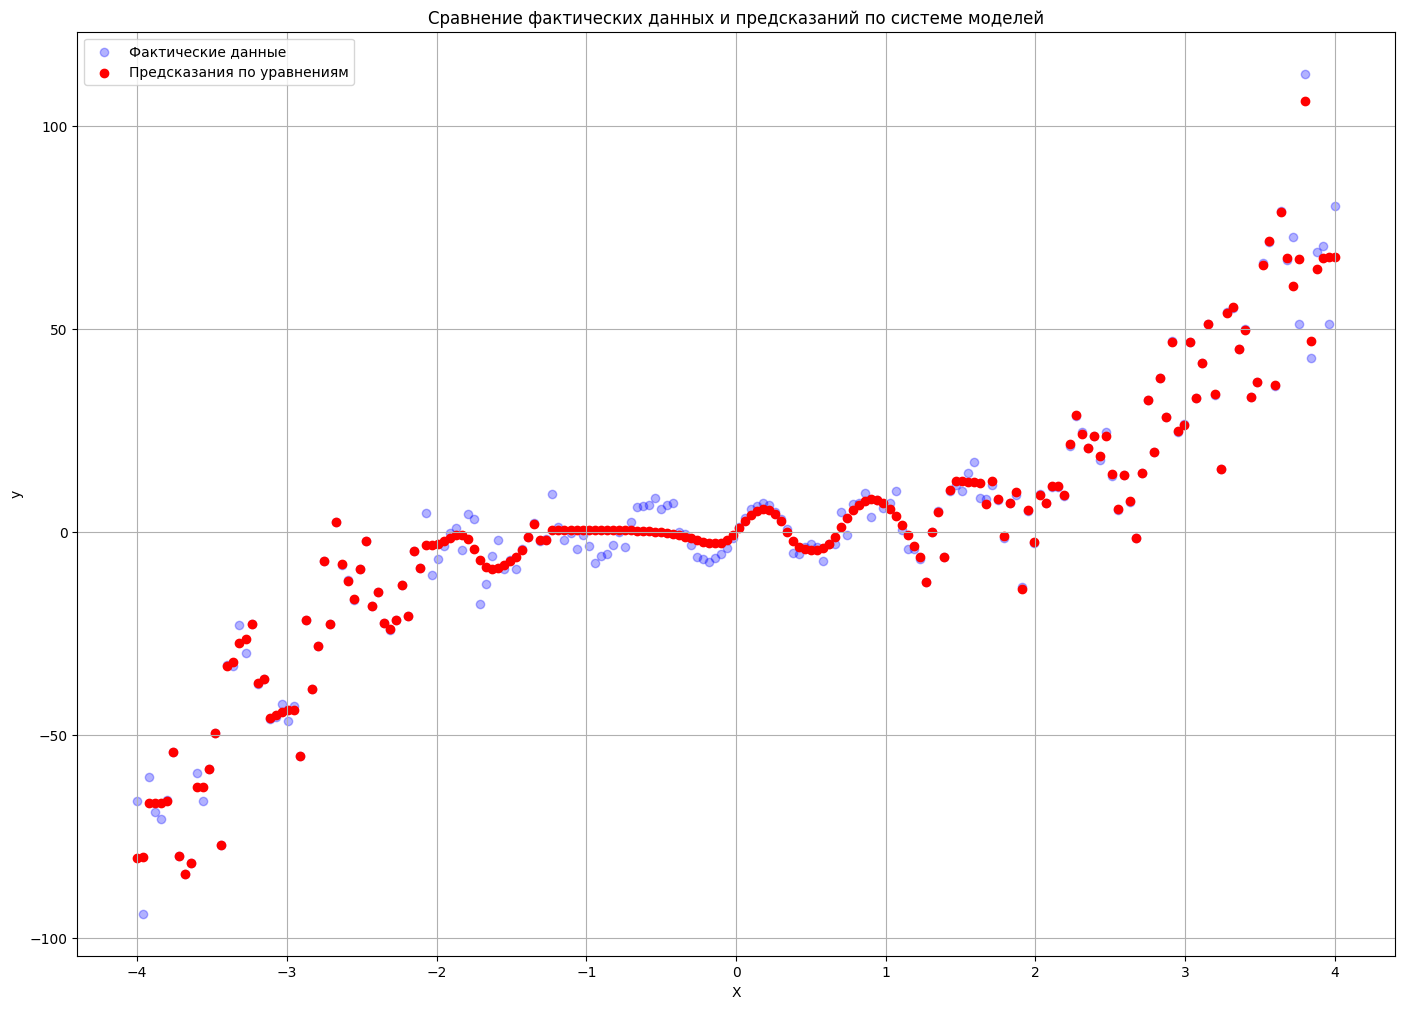

In [121]:
def ensemble_predict_equations(X):
    # Функция предсказания
    predictions = []
    for x in X:
        x_val = x.item()
        
        if x_val < -1.25:
            pred = model1_equation(x_val)
        elif x_val > 1.25:
            pred = model3_equation(x_val)
        else:
            pred = model2_equation(x_val)
            
        predictions.append([pred])
    
    return np.array(predictions)  


y_pred_eq = ensemble_predict_equations(X_pred)

plt.figure(figsize=(17, 12))
plt.scatter(X.numpy(), y.numpy(), color='blue', alpha=0.3, label='Фактические данные')
plt.scatter(X_pred.numpy(), y_pred_eq, color='red', label='Предсказания по уравнениям')
plt.title('Сравнение фактических данных и предсказаний по системе моделей')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()